In [2]:
%pip install duckdb requests pandas numpy seaborn matplotlib scikit-learn xgboost optuna optuna-integration[xgboost]

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Standard Library Imports
import os
import gc
import shutil

# Data Handling & API
import requests
import duckdb
import numpy as np
import pandas as pd

# Machine Learning & Optimization
import optuna
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from optuna.integration import XGBoostPruningCallback
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def download(url):
    fname = url.split("/")[-1]
    with open(fname, "wb") as f:
        f.write(requests.get(url).content)
    print(f"Downloaded {fname}")

download("https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf")
download("https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv")


Downloaded data_dictionary_trip_records_yellow.pdf
Downloaded taxi_zone_lookup.csv


In [5]:
# 1. Setup directory
data_dir = "original_data"
os.makedirs(data_dir, exist_ok=True)

base = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
months = [f"yellow_tripdata_2023-{m:02d}.parquet" for m in range(1, 13)]

# 2. Download loop with existence check
for file_name in months:
    file_path = os.path.join(data_dir, file_name)

    if os.path.exists(file_path):
        print(f"Found {file_name}, skipping download.")
    else:
        url = base + file_name
        try:
            with requests.get(url, stream=True) as r:
                r.raise_for_status()
                with open(file_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=1024*1024):
                        if chunk:
                            f.write(chunk)
            print(f"Successfully downloaded {file_name}")
        except Exception as e:
            print(f"Failed to download {file_name}: {e}")
            # Optional: Remove partial file if download fails
            if os.path.exists(file_path):
                os.remove(file_path)

# 3. Merge files from the folder into the current directory
print("Merging files with DuckDB...")
duckdb.sql(f"""
    COPY (
        SELECT * FROM '{data_dir}/yellow_tripdata_2023-*.parquet'
    )
    TO 'yellow_2023_tripdata.parquet'
    (FORMAT PARQUET);
""")

print("Done. Merged file created: yellow_2023_tripdata.parquet")

Successfully downloaded yellow_tripdata_2023-01.parquet
Successfully downloaded yellow_tripdata_2023-02.parquet
Successfully downloaded yellow_tripdata_2023-03.parquet
Successfully downloaded yellow_tripdata_2023-04.parquet
Successfully downloaded yellow_tripdata_2023-05.parquet
Successfully downloaded yellow_tripdata_2023-06.parquet
Successfully downloaded yellow_tripdata_2023-07.parquet
Successfully downloaded yellow_tripdata_2023-08.parquet
Successfully downloaded yellow_tripdata_2023-09.parquet
Successfully downloaded yellow_tripdata_2023-10.parquet
Successfully downloaded yellow_tripdata_2023-11.parquet
Successfully downloaded yellow_tripdata_2023-12.parquet
Merging files with DuckDB...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done. Merged file created: yellow_2023_tripdata.parquet


In [ ]:
file_path = "yellow_2023_tripdata.parquet"

if os.path.exists(file_path):
    file_size_bytes = os.path.getsize(file_path)
    file_size_gb = file_size_bytes / (1024 * 1024 * 1024)
    print(f"The size of '{file_path}' is {file_size_gb:.2f} GB")
else:
    print(f"File '{file_path}' not found.")

The size of '/content/yellow_2023_tripdata.parquet' is 0.76 GB


In [ ]:
def parquet_info(path):
    con = duckdb.connect()

    # total rows
    total_rows = con.sql(f"SELECT count(*) AS rows FROM '{path}'").fetchone()[0]

    # column names
    cols = con.sql(f"DESCRIBE SELECT * FROM '{path}'").df()
    col_names = cols["column_name"].tolist()

    # null counts per column (safe for large files)
    null_counts = {}
    for c in col_names:
        q = f"SELECT count(*) - count({c}) AS nulls FROM '{path}'"
        null_counts[c] = con.sql(q).fetchone()[0]

    return {
        "total_rows": total_rows,
        "columns": cols,
        "null_counts": null_counts
    }


info = parquet_info("yellow_2023_tripdata.parquet")
print("Rows:", info["total_rows"])
print(info["columns"])
print(info["null_counts"])


Rows: 38310226
              column_name column_type null   key default extra
0                VendorID      BIGINT  YES  None    None  None
1    tpep_pickup_datetime   TIMESTAMP  YES  None    None  None
2   tpep_dropoff_datetime   TIMESTAMP  YES  None    None  None
3         passenger_count      DOUBLE  YES  None    None  None
4           trip_distance      DOUBLE  YES  None    None  None
5              RatecodeID      DOUBLE  YES  None    None  None
6      store_and_fwd_flag     VARCHAR  YES  None    None  None
7            PULocationID      BIGINT  YES  None    None  None
8            DOLocationID      BIGINT  YES  None    None  None
9            payment_type      BIGINT  YES  None    None  None
10            fare_amount      DOUBLE  YES  None    None  None
11                  extra      DOUBLE  YES  None    None  None
12                mta_tax      DOUBLE  YES  None    None  None
13             tip_amount      DOUBLE  YES  None    None  None
14           tolls_amount      DOUBLE  Y

In [ ]:
con = duckdb.connect()
table_name = 'yellow_2023_tripdata.parquet'

try:
    all_columns_info = con.sql(f"DESCRIBE SELECT * FROM '{table_name}'").fetchall()
    all_columns = [info[0] for info in all_columns_info]

    print(f"✅ Successfully found {len(all_columns)} columns.")

except Exception as e:
    print(f"Error retrieving column names for table '{table_name}': {e}")
    all_columns = []

LENGTH_THRESHOLD = 20

print("🔍 Unique values assessment for all columns:")
print("-" * 40)

for col in all_columns:
    try:
        count_query = f"SELECT COUNT(DISTINCT {col}) FROM '{table_name}'"
        unique_count = con.sql(count_query).fetchone()[0]

        print(f"\nColumn: {col} (Unique Count: {unique_count})")

        if unique_count > LENGTH_THRESHOLD:
            stats_query = f"SELECT MIN({col}), MAX({col}) FROM '{table_name}'"
            stats = con.sql(stats_query).fetchone()

            first_entry = stats[0]
            last_entry = stats[1]

            print(f"> Results are too long (>{LENGTH_THRESHOLD}). Displaying Range:")
            print(f"   Min: {first_entry}")
            print(f"   Max: {last_entry}")

        else:
            all_unique_query = f"SELECT DISTINCT {col} FROM '{table_name}' ORDER BY {col} ASC"
            unique_values = con.sql(all_unique_query).fetchall()
            print("   All Unique Values:")
            print([val[0] for val in unique_values])

    except Exception as e:
        print(f"❌ An error occurred while processing column '{col}': {e}")

print("-" * 40)

✅ Successfully found 19 columns.
🔍 Unique values assessment for all columns:
----------------------------------------

Column: VendorID (Unique Count: 3)
   All Unique Values:
[1, 2, 6]


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Column: tpep_pickup_datetime (Unique Count: 19448115)
> Results are too long (>20). Displaying Range:
   Min: 2001-01-01 00:06:49
   Max: 2024-01-03 19:42:57


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Column: tpep_dropoff_datetime (Unique Count: 19438809)
> Results are too long (>20). Displaying Range:
   Min: 1970-01-20 10:16:32
   Max: 2024-01-03 20:15:55

Column: passenger_count (Unique Count: 10)
   All Unique Values:
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, None]

Column: trip_distance (Unique Count: 8493)
> Results are too long (>20). Displaying Range:
   Min: 0.0
   Max: 345729.44

Column: RatecodeID (Unique Count: 7)
   All Unique Values:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 99.0, None]

Column: store_and_fwd_flag (Unique Count: 2)
   All Unique Values:
['N', 'Y', None]

Column: PULocationID (Unique Count: 263)
> Results are too long (>20). Displaying Range:
   Min: 1
   Max: 265

Column: DOLocationID (Unique Count: 262)
> Results are too long (>20). Displaying Range:
   Min: 1
   Max: 265

Column: payment_type (Unique Count: 6)
   All Unique Values:
[0, 1, 2, 3, 4, 5]

Column: fare_amount (Unique Count: 15122)
> Results are too long (>20). Displaying Range:
   Min: -10

**Note: The negative values are refunds and the dataset is only of Year 2023**

VendorID — Which taxi company/system recorded the trip.
* 1: Creative Mobile Technologies
* 2: Curb Mobility, LLC
* 6: Myle Technologies Inc

tpep_pickup_datetime — When the trip started
* Time series

tpep_dropoff_datetime — When the trip ended
* Time series

passenger_count — Number of passengers
* Entered by Driver

trip_distance — Distance traveled in miles
* Variable

RatecodeID — Final rate type used for the fare
* 1 = Standard rate
* 2 = JFK(132), Airport
* 3 = Newark(1), Airport
* 4 = Nassau or Westchester(Outside of NYC: 265)
* 5 = Negotiated fare
* 6 = Group ride
* 99 = Null/unknown(264)

store_and_fwd_flag — Taxi's internet connection at the end of the trip
* N: No
* Y: Yes

PULocationID — Zone where the trip started
* Ranging from 1-265

DOLocationID — Zone where the trip ended
* Ranging from 1-265

payment_type — How the passenger paid
* 1 (Credit) & 2 (Cash)
* 3 (No Charge) & 4 (Dispute)
* 5 (Unknown) & 0 (Void)

fare_amount — Base fare determined by meter
* Calculated, Dependent on trip_distance

extra — Extra surcharges (like night fee, rush hour, etc.)
* \$ 0.00: No Surcharge, Trips during standard hours (e.g., weekdays 6 AM - 4 PM) outside of surcharge zones.
* \$ 1.00: Overnight Surcharge, Applies daily from 8:00 PM to 6:00 AM. (Increased from $0.50 in prior years).
* \$ 2.50: Rush Hour Surcharge, Applies 4:00 PM to 8:00 PM on weekdays (Monday–Friday). (Increased from \$ 1.00 in prior years).
* \$ 5.00: LGA Surcharge, A new surcharge added in 2023 for all trips to/from LaGuardia Airport.
* \$ 5.00	JFK Rush Hour	Surcharge, added to the JFK Flat Fare during rush hour (4 PM - 8 PM Weekdays).

mta_tax — Standard MTA tax
* The values must be \$0.50(Standard) or \$0.00(Exempt)

tip_amount — Tip (credit card only)
* Variable

tolls_amount — Toll charges during the trip
* Variable

improvement_surcharge — Mandatory fee added since 2015
* \$ 1.0 / -1.0 / 0.0: (Standard / Refund / Exempt).

total_amount — Total charged (excluding cash tip)
* Variable

congestion_surcharge — Congestion pricing fee
* \$ 2.50: Standard Yellow Taxi trip touching Manhattan.
* \$ 0.00: Trips entirely outside Manhattan.

airport_fee — Fee for pickups at Airports
* \$ 1.75 (or \$ 1.25 early in year): Only for pickups at LGA/JFK.
* \$ 0.00: Non-airport trips.


Sources:

https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data

https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv


## **EDA and Domain Rules**

### **1. Time and Trip Validity**

Only trips from **2023** are valid.
Pickup and dropoff times must both fall in 2023.
Duration must be positive and realistic (1 to 240 minutes).
Distance must be positive.

### **2. Passenger, Distance, and Speed**

Passenger count cannot be zero.
Trip distance cannot be zero or negative.
Calculated speed must be below **80 mph**, because speeds above this are physically unrealistic in NYC traffic.

### **3. Fare Structure Rules (Fixed TLC logic)**

These components of the fare are fixed by NYC TLC policy:

* **MTA tax**: Must be **\$0.50** for Ratecodes 1–4.
* **Improvement surcharge**: Always **\$1.00**.
* **Congestion surcharge**: either **\$0.00** or **\$2.50**.
* **Airport fee**:

  * **\$1.75** for JFK
  * **\$1.25** for LaGuardia
  * **\$0.00** otherwise
* **Tolls**: Normally between **\$0 and \$30**.

### **4. Ratecodes and Payment Types**

Keep only trips where:

* **RatecodeID ∈ {1, 2, 4}**
* **Payment type ∈ {1 (Credit), 2 (Cash)}**

Dropped Ratecodes 3, 5, 6, 99 due to tiny sample size and unusable logic.

### **5. Extra**

The raw `extra` column mixes:

* Rush-hour surcharge
* Airport surcharge (in a broken/bundled way)

In practice:

* Valid `extra` values are **0, 0.5, 1, 2.5, 5, 6, 7.5**
* For JFK (132) or LGA (138):

  * Subtract **\$5** as airport surcharge
  * The remainder is the rush-hour surcharge
* For all other locations:

  * `extra` is treated as the rush-hour surcharge directly

### **6. Vendor Bugs**

#### **Vendor 1 Bug – Missing Surcharges**

Vendor 1 reported all surcharges *correctly in their columns*, but **failed to add them into `total_amount`**.
This creates negative discrepancies:

* –2.50 (missing congestion fee)
* –1.25 (missing LGA fee)
* –1.75 (missing JFK fee)
* –3.75 (missing congestion + LGA)
* –4.25 (missing congestion + JFK)

Fix: recomputed `total_amount`.

#### **Vendor 2 Bug – Cash Payments Missing Tips**

Vendor 2 mishandles cash trips:

* `total_amount` is correct
* `tip_amount` is NULL or 0

This causes positive discrepancies.
Fix: set `tip_amount = discrepancy` for VendorID=2, payment_type=2.

### **7. Mathematical Consistency**

After fixes, the following equation **must balance exactly**:

```
total_amount =
fare_amount
+ airport_surcharge
+ rushhour_surcharge
+ mta_tax
+ improvement_surcharge
+ congestion_surcharge
+ airport_fee
+ tip_amount
+ tolls_amount
```

Any row failing this check is garbage.



In [6]:
def clean_data(input_file, output_file):
    if not os.path.exists(input_file):
        print(f"Error: The file '{input_file}' was not found.")
        return

    con = duckdb.connect()

    try:
        initial_count = con.execute(f"SELECT COUNT(*) FROM '{input_file}'").fetchone()[0]
        print(f"Initial record count: {initial_count}")

        if initial_count == 0:
            print("Input file is empty.")
            return

        # Get columns to build dynamic non-null checks
        columns_info = con.execute(f"SELECT * FROM '{input_file}' LIMIT 1").description
        column_names = [col[0] for col in columns_info]
        non_null_conditions = " AND ".join([f'"{col}" IS NOT NULL' for col in column_names])

        query = f"""
        COPY (
            WITH step1_prelim AS (
                -- STAGE 1: Basic Filtering, Time Calculation & Feature Engineering
                SELECT *,
                    -- Calculate Duration
                    date_diff('minute', tpep_pickup_datetime, tpep_dropoff_datetime) AS duration_min,

                    -- Feature Engineering: Extract Hour, Day, Month
                    EXTRACT('hour' FROM tpep_pickup_datetime) AS pickup_hour,
                    (EXTRACT('isodow' FROM tpep_pickup_datetime) - 1) AS pickup_day, -- 1=Mon -> 0=Mon
                    EXTRACT('month' FROM tpep_pickup_datetime) AS pickup_month,

                    -- Split 'extra' into airport_surcharge and rushhour_surcharge
                    -- Logic: If Pickup/Dropoff is JFK (132) or LaGuardia (138) AND extra is high (5, 6, 7.5),
                    -- then $5 is airport fee, remainder is rush hour.
                    CASE
                        WHEN (PULocationID IN (132, 138) OR DOLocationID IN (132, 138))
                             AND extra IN (5, 6, 7.5) THEN 5.0
                        ELSE 0.0
                    END AS airport_surcharge,

                    CASE
                        WHEN (PULocationID IN (132, 138) OR DOLocationID IN (132, 138))
                             AND extra IN (5, 6, 7.5) THEN extra - 5.0
                        ELSE extra
                    END AS rushhour_surcharge

                FROM '{input_file}'
                WHERE
                    {non_null_conditions}
                    AND extract('year' FROM tpep_pickup_datetime) = 2023
                    AND extract('year' FROM tpep_dropoff_datetime) = 2023
                    AND passenger_count > 0
                    AND trip_distance > 0
                    AND fare_amount > 0
                    AND tip_amount >= 0
                    AND tolls_amount BETWEEN 0 AND 25
                    AND extra IN (0, 0.5, 1, 2.50, 5, 5.50, 6, 7.50)
                    AND payment_type IN (1, 2)
                    AND RatecodeID IN (1, 2, 4)
                    AND mta_tax IN (0.5)
                    AND improvement_surcharge IN (1.0)
                    AND congestion_surcharge IN (0.0, 2.50)
                    AND airport_fee IN (0.0, 1.25, 1.75)
            ),

            step2_calc_discrepancy AS (
                -- STAGE 2: Calculate the Math Gap
                SELECT *,
                    ROUND(total_amount - (
                        fare_amount + airport_surcharge + rushhour_surcharge + mta_tax + improvement_surcharge +
                        COALESCE(congestion_surcharge, 0) +
                        COALESCE(airport_fee, 0) +
                        tip_amount + tolls_amount
                    ), 2) AS discrepancy
                FROM step1_prelim
            ),

            step3_repair AS (
                -- STAGE 3: Apply Vendor-Specific Logic & Drop Original Dates
                SELECT
                    -- Exclude original datetime columns here
                    * EXCLUDE (
                        tip_amount,
                        total_amount,
                        discrepancy,
                        extra,
                        tpep_pickup_datetime,
                        tpep_dropoff_datetime
                    ),

                    -- 1. REPAIR TIP AMOUNT (Vendor 2 Cash Bug)
                    CASE
                        WHEN VendorID = 2
                             AND payment_type = 2
                             AND discrepancy > 0
                        THEN discrepancy
                        ELSE tip_amount
                    END AS tip_amount,

                    -- 2. REPAIR TOTAL AMOUNT (Vendor 1 Logging Bug)
                    CASE
                        WHEN VendorID = 1 THEN (
                            fare_amount + airport_surcharge + rushhour_surcharge + mta_tax + improvement_surcharge +
                            COALESCE(congestion_surcharge, 0) +
                            COALESCE(airport_fee, 0) +
                            tip_amount + tolls_amount
                        )
                        ELSE total_amount
                    END AS total_amount,

                    -- CALCULATE SPEED (mph)
                    (trip_distance / (duration_min / 60.0)) AS average_speed_mph

                FROM step2_calc_discrepancy
            )

            -- STAGE 4: Final Outlier Filtering & STRICT MATH CHECK
            SELECT * FROM step3_repair
            WHERE
                trip_distance <= 100
                AND total_amount <= 1000
                AND duration_min BETWEEN 1 AND 240
                AND average_speed_mph BETWEEN 0.1 AND 80
                AND tip_amount <= (total_amount * 0.32)

                -- Math Check: Only keep rows where the math finally works
                AND ROUND(total_amount - (
                        fare_amount + airport_surcharge + rushhour_surcharge + mta_tax + improvement_surcharge +
                        COALESCE(congestion_surcharge, 0) +
                        COALESCE(airport_fee, 0) +
                        tip_amount + tolls_amount
                    ), 2) = 0

        ) TO '{output_file}' (FORMAT 'PARQUET')
        """

        con.execute(query)

        final_count = con.execute(f"SELECT COUNT(*) FROM '{output_file}'").fetchone()[0]
        print(f"Final record count: {final_count}")

        lost_records = initial_count - final_count
        percent_loss = (lost_records / initial_count) * 100

        print(f"-" * 40)
        print(f"Data Loss: {percent_loss:.2f}%")
        print(f"Records Removed: {lost_records}")
        print(f"-" * 40)
        print("Done.")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        con.close()

if __name__ == "__main__":
    INPUT_FILENAME = 'yellow_2023_tripdata.parquet'
    OUTPUT_FILENAME = 'cleaned_yellow_2023_tripdata.parquet'

    clean_data(INPUT_FILENAME, OUTPUT_FILENAME)

    # Swap files
    if os.path.exists(OUTPUT_FILENAME):
        if os.path.exists(INPUT_FILENAME):
            os.remove(INPUT_FILENAME)
        os.rename(OUTPUT_FILENAME, INPUT_FILENAME)
        print(f"Original file '{INPUT_FILENAME}' has been overwritten with cleaned data.")

Initial record count: 38310226


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Final record count: 32036721
----------------------------------------
Data Loss: 16.38%
Records Removed: 6273505
----------------------------------------
Done.
Original file 'yellow_2023_tripdata.parquet' has been overwritten with cleaned data.


In [ ]:
con = duckdb.connect()
table_name = 'yellow_2023_tripdata.parquet'

try:
    all_columns_info = con.sql(f"DESCRIBE SELECT * FROM '{table_name}'").fetchall()
    all_columns = [info[0] for info in all_columns_info]

    print(f"✅ Successfully found {len(all_columns)} columns.")

except Exception as e:
    print(f"Error retrieving column names for table '{table_name}': {e}")
    all_columns = []

LENGTH_THRESHOLD = 20

print("🔍 Unique values assessment for all columns:")
print("-" * 40)

for col in all_columns:
    try:
        count_query = f"SELECT COUNT(DISTINCT {col}) FROM '{table_name}'"
        unique_count = con.sql(count_query).fetchone()[0]

        print(f"\nColumn: {col} (Unique Count: {unique_count})")

        if unique_count > LENGTH_THRESHOLD:
            stats_query = f"SELECT MIN({col}), MAX({col}) FROM '{table_name}'"
            stats = con.sql(stats_query).fetchone()

            first_entry = stats[0]
            last_entry = stats[1]

            print(f"> Results are too long (>{LENGTH_THRESHOLD}). Displaying Range:")
            print(f"   Min: {first_entry}")
            print(f"   Max: {last_entry}")

        else:
            all_unique_query = f"SELECT DISTINCT {col} FROM '{table_name}' ORDER BY {col} ASC"
            unique_values = con.sql(all_unique_query).fetchall()
            print("   All Unique Values:")
            print([val[0] for val in unique_values])

    except Exception as e:
        print(f"❌ An error occurred while processing column '{col}': {e}")

print("-" * 40)

✅ Successfully found 23 columns.
🔍 Unique values assessment for all columns:
----------------------------------------

Column: VendorID (Unique Count: 2)
   All Unique Values:
[1, 2]

Column: passenger_count (Unique Count: 6)
   All Unique Values:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Column: trip_distance (Unique Count: 5607)
> Results are too long (>20). Displaying Range:
   Min: 0.01
   Max: 99.62

Column: RatecodeID (Unique Count: 3)
   All Unique Values:
[1.0, 2.0, 4.0]

Column: store_and_fwd_flag (Unique Count: 2)
   All Unique Values:
['N', 'Y']

Column: PULocationID (Unique Count: 260)
> Results are too long (>20). Displaying Range:
   Min: 1
   Max: 265

Column: DOLocationID (Unique Count: 262)
> Results are too long (>20). Displaying Range:
   Min: 1
   Max: 265

Column: payment_type (Unique Count: 2)
   All Unique Values:
[1, 2]

Column: fare_amount (Unique Count: 1367)
> Results are too long (>20). Displaying Range:
   Min: 0.7
   Max: 680.6

Column: mta_tax (Unique Count: 1)
   

In [ ]:
con = duckdb.connect()

trip_file = 'yellow_2023_tripdata.parquet'

print("Analyzing Congestion Surcharge patterns for top routes...")

query = f"""
WITH RankedRoutes AS (
    SELECT
        t.PULocationID,
        t.DOLocationID,
        t.congestion_surcharge,  -- Select the surcharge
        COUNT(*) AS freq,
        ROW_NUMBER() OVER (
            PARTITION BY t.congestion_surcharge -- Partition by surcharge if useful, or remove PARTITION BY
            ORDER BY COUNT(*) DESC
        ) AS rank
    FROM '{trip_file}' t
    GROUP BY t.PULocationID, t.DOLocationID, t.congestion_surcharge
)
SELECT *
FROM RankedRoutes
WHERE rank <= 12  -- Increased limit to see if 'split' behaviors appear
ORDER BY freq DESC
"""

df = con.execute(query).fetchdf()

con.close()

print(f"{'Route (PU -> DO)':<25} | {'Surcharge':<10} | {'Freq':<10}")
print("-" * 50)

for index, row in df.iterrows():
    freq = int(row['freq'])

    # Handle formatting for the surcharge
    surch_val = row['congestion_surcharge']
    surch_str = f"${surch_val:.2f}" if pd.notnull(surch_val) else "None"

    route_str = f"{int(row['PULocationID'])} -> {int(row['DOLocationID'])}"

    print(f"{route_str:<25} | {surch_str:<10} | {freq:<10}")

con.close()


Analyzing Congestion Surcharge patterns for top routes...
Route (PU -> DO)          | Surcharge  | Freq      
--------------------------------------------------
237 -> 236                | $2.50      | 235617    
236 -> 237                | $2.50      | 204888    
264 -> 264                | $2.50      | 178091    
237 -> 237                | $2.50      | 155057    
236 -> 236                | $2.50      | 150418    
161 -> 237                | $2.50      | 110942    
237 -> 161                | $2.50      | 109655    
161 -> 236                | $2.50      | 94293     
142 -> 239                | $2.50      | 87707     
239 -> 142                | $2.50      | 86298     
237 -> 162                | $2.50      | 85851     
239 -> 238                | $2.50      | 83732     
264 -> 264                | $0.00      | 59125     
132 -> 265                | $0.00      | 42175     
132 -> 132                | $0.00      | 23617     
132 -> 10                 | $0.00      | 21193     
132 -> 

If `PULocationID` or `DOLocationID` == [236-239] ie Manhattan Upper East & West Side, then `congestion_surcharge` = 2.50. These are residential giants, hence the high internal traffic. Otherwise, there's no congestion surcharge

In [ ]:
con = duckdb.connect()

trip_file = 'yellow_2023_tripdata.parquet'

print("Calculating top routes using only Location IDs...")

# 2. SQL Query
query = f"""
WITH RankedRoutes AS (
    SELECT
        t.RatecodeID,
        t.PULocationID,
        t.DOLocationID,
        COUNT(*) AS freq,
        ROW_NUMBER() OVER (
            PARTITION BY t.RatecodeID
            ORDER BY COUNT(*) DESC
        ) AS rank
    FROM '{trip_file}' t
    WHERE t.RatecodeID IN (1, 2, 4)
    GROUP BY t.RatecodeID, t.PULocationID, t.DOLocationID
)
SELECT *
FROM RankedRoutes
WHERE rank <= 15
ORDER BY RatecodeID, freq DESC;
"""

# 3. Fetch results
df = con.execute(query).fetchdf()

# Close connection only once
con.close()

# 4. Print results
rate_codes = {
    1: "Standard Rate",
    2: "JFK Airport",
    4: "Nassau/Westchester"
}

print(f"{'Ratecode':<20} | {'Route (PickupID -> DropoffID)':<40} | {'Freq':<10}")
print("-" * 80)

for index, row in df.iterrows():
    r_id = int(row['RatecodeID'])
    freq = int(row['freq'])
    route_str = f"{int(row['PULocationID'])} -> {int(row['DOLocationID'])}"
    rate_str = f"{r_id} ({rate_codes.get(r_id, 'Other')})"

    print(f"{rate_str:<20} | {route_str:<40} | {freq:<10}")

    # Add divider between different RatecodeID blocks
    if index < len(df) - 1 and df.iloc[index + 1]['RatecodeID'] != r_id:
        print("-" * 80)


Calculating top routes using only Location IDs...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Ratecode             | Route (PickupID -> DropoffID)            | Freq      
--------------------------------------------------------------------------------
1 (Standard Rate)    | 237 -> 236                               | 235722    
1 (Standard Rate)    | 264 -> 264                               | 226623    
1 (Standard Rate)    | 236 -> 237                               | 204985    
1 (Standard Rate)    | 237 -> 237                               | 154972    
1 (Standard Rate)    | 236 -> 236                               | 150419    
1 (Standard Rate)    | 161 -> 237                               | 111001    
1 (Standard Rate)    | 237 -> 161                               | 109686    
1 (Standard Rate)    | 161 -> 236                               | 94356     
1 (Standard Rate)    | 142 -> 239                               | 87770     
1 (Standard Rate)    | 239 -> 142                               | 86328     
1 (Standard Rate)    | 237 -> 162                               | 85881 

This shows that
* If `PULocationID` or `DOLocationID` == 132, Then `RatecodeID` == 2
* If `DOLocation` == 265 or 86, Then `RatecodeID` == 4
* Else `RatecodeID` ==1

In [ ]:
con = duckdb.connect()

trip_file = 'yellow_2023_tripdata.parquet'

print("Calculating top routes using only Location IDs, partitioned by airport_surcharge...")
query = f"""
WITH RankedRoutes AS (
    SELECT
        t.airport_surcharge,
        t.PULocationID,
        t.DOLocationID,
        COUNT(*) AS freq,
        ROW_NUMBER() OVER (
            PARTITION BY t.airport_surcharge
            ORDER BY COUNT(*) DESC
        ) AS rank
    FROM '{trip_file}' t
    GROUP BY t.airport_surcharge, t.PULocationID, t.DOLocationID
)
SELECT *
FROM RankedRoutes
WHERE rank <= 18
ORDER BY airport_surcharge, freq DESC
"""

df = con.execute(query).fetchdf()

# 3. Print Results
print(f"{'Airport Surcharge':<20} | {'Route (PickupID -> DropoffID)':<40} | {'Freq':<10}")
print("-" * 80)

for index, row in df.iterrows():
    surcharge_val = row['airport_surcharge']
    freq = int(row['freq'])

    route_str = f"{int(row['PULocationID'])} -> {int(row['DOLocationID'])}"
    surcharge_str = f"${surcharge_val:.2f}"

    print(f"{surcharge_str:<20} | {route_str:<40} | {freq:<10}")

    if index < len(df)-1 and df.iloc[index+1]['airport_surcharge'] != surcharge_val:
        print("-" * 80)

con.close()


Calculating top routes using only Location IDs, partitioned by airport_surcharge...
Airport Surcharge    | Route (PickupID -> DropoffID)            | Freq      
--------------------------------------------------------------------------------
$0.00                | 264 -> 264                               | 237216    
$0.00                | 237 -> 236                               | 235745    
$0.00                | 236 -> 237                               | 205007    
$0.00                | 237 -> 237                               | 155153    
$0.00                | 236 -> 236                               | 150569    
$0.00                | 161 -> 237                               | 111010    
$0.00                | 237 -> 161                               | 109699    
$0.00                | 161 -> 236                               | 94361     
$0.00                | 142 -> 239                               | 87773     
$0.00                | 239 -> 142                               |

If `PULocationID` or `DOLocationID` = 138, Then `airport_surcharge` = \$ 5.00

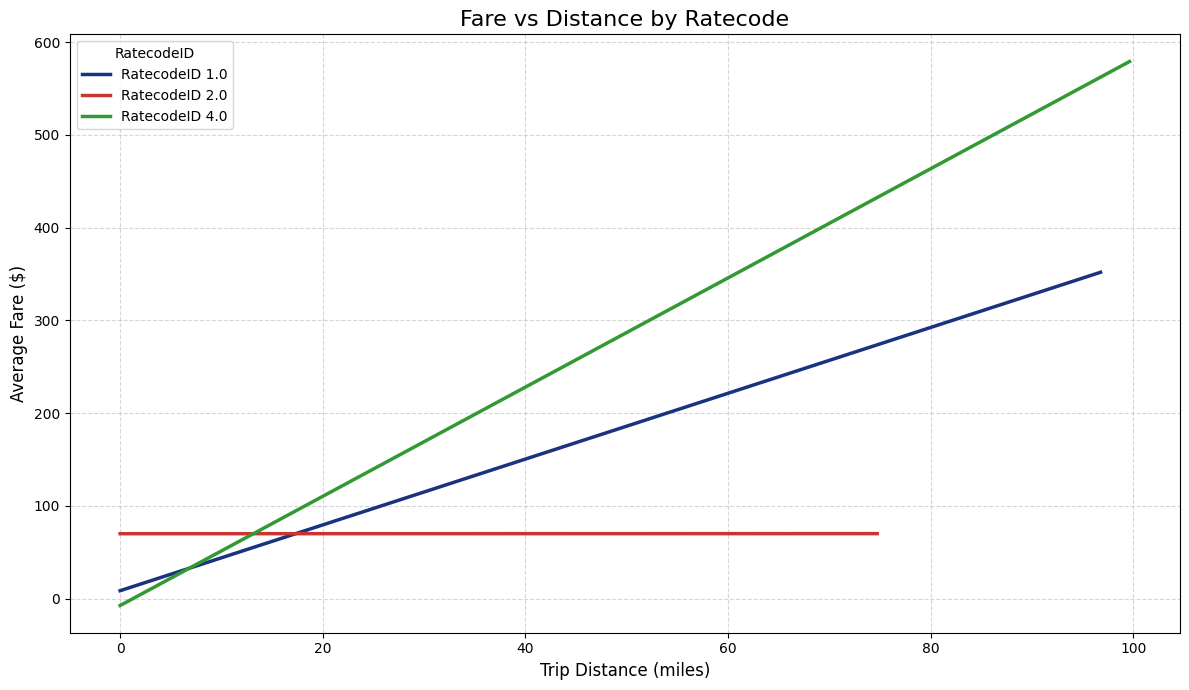

In [ ]:

con = duckdb.connect()
trip_file = 'yellow_2023_tripdata.parquet'

query = f"""
SELECT
    RatecodeID,
    trip_distance,
    AVG(fare_amount) AS avg_fare
FROM '{trip_file}'
WHERE trip_distance > 0
  AND fare_amount > 0
GROUP BY RatecodeID, trip_distance
ORDER BY RatecodeID, trip_distance
"""

df_fare_by_distance = con.execute(query).fetchdf()
con.close()

rgb_colors = {
    1: (0.1, 0.2, 0.5),
    2: (0.8, 0.2, 0.2),
    4: (0.2, 0.6, 0.2),
}

plt.figure(figsize=(12, 7))

unique_rates = sorted(df_fare_by_distance['RatecodeID'].unique())

for rate_id in unique_rates:
    subset = df_fare_by_distance[df_fare_by_distance['RatecodeID'] == rate_id]

    sns.regplot(
        data=subset,
        x='trip_distance',
        y='avg_fare',
        scatter=False,
        label=f'RatecodeID {rate_id}',
        color=rgb_colors.get(rate_id, (0, 0, 0)),
        ci=None,
        line_kws={'linewidth': 2.5}
    )

plt.title('Fare vs Distance by Ratecode', fontsize=16)
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Average Fare ($)', fontsize=12)  # fix label too
plt.legend(title='RatecodeID')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


`RatecodeID` = 2, incurs a fixed fare_amount = \$ 70

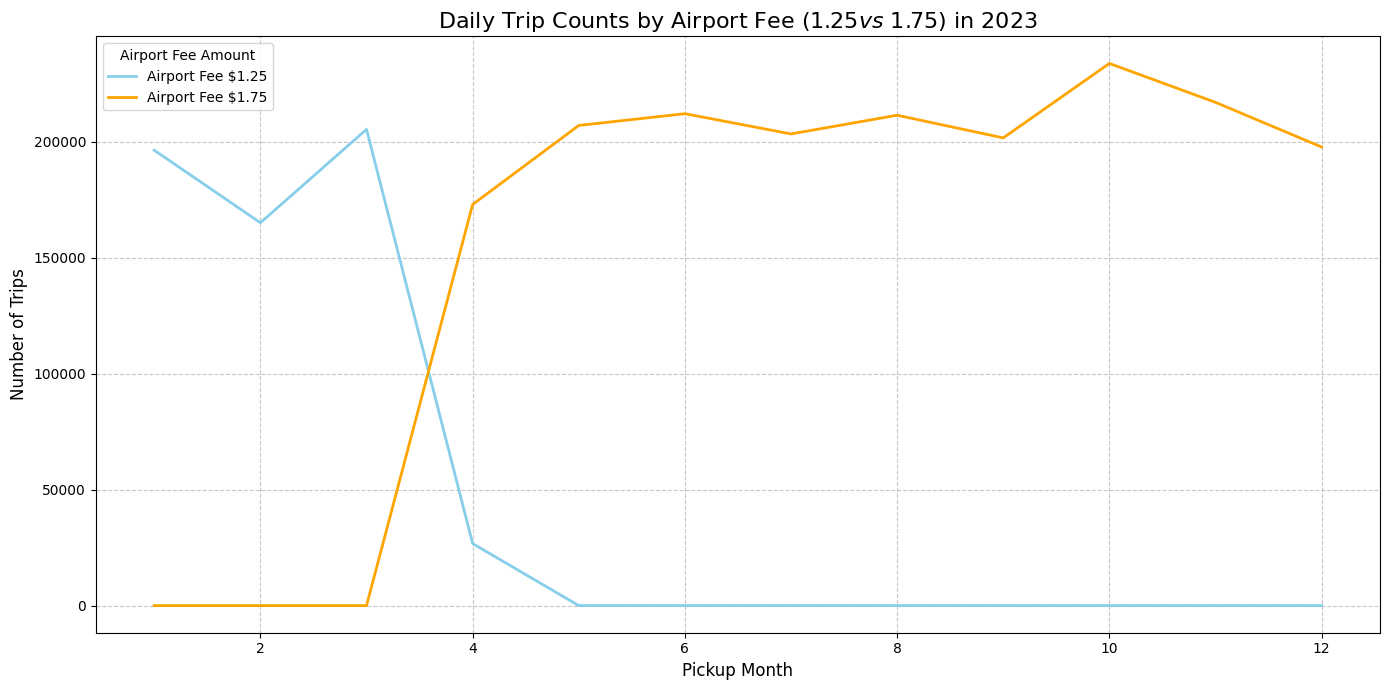

In [ ]:
con = duckdb.connect()

query = """
SELECT
    pickup_month,
    airport_fee,
    COUNT(*) AS trip_count
FROM 'yellow_2023_tripdata.parquet'
WHERE airport_fee IN (1.25, 1.75)
GROUP BY 1, 2
ORDER BY 1, 2
"""

df_airport_fees_over_time = con.execute(query).fetchdf()
con.close()


df_pivot = df_airport_fees_over_time.pivot(index='pickup_month', columns='airport_fee', values='trip_count').fillna(0)

plt.figure(figsize=(14, 7))

if 1.25 in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[1.25], label='Airport Fee $1.25', color='skyblue', linewidth=2)

if 1.75 in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[1.75], label='Airport Fee $1.75', color='orange', linewidth=2)

plt.title('Daily Trip Counts by Airport Fee ($ 1.25 vs $ 1.75) in 2023', fontsize=16)
plt.xlabel('Pickup Month', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.legend(title='Airport Fee Amount', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


This showed that `airport_fee` increased from \$ 1.25 to \$ 1.75 after March

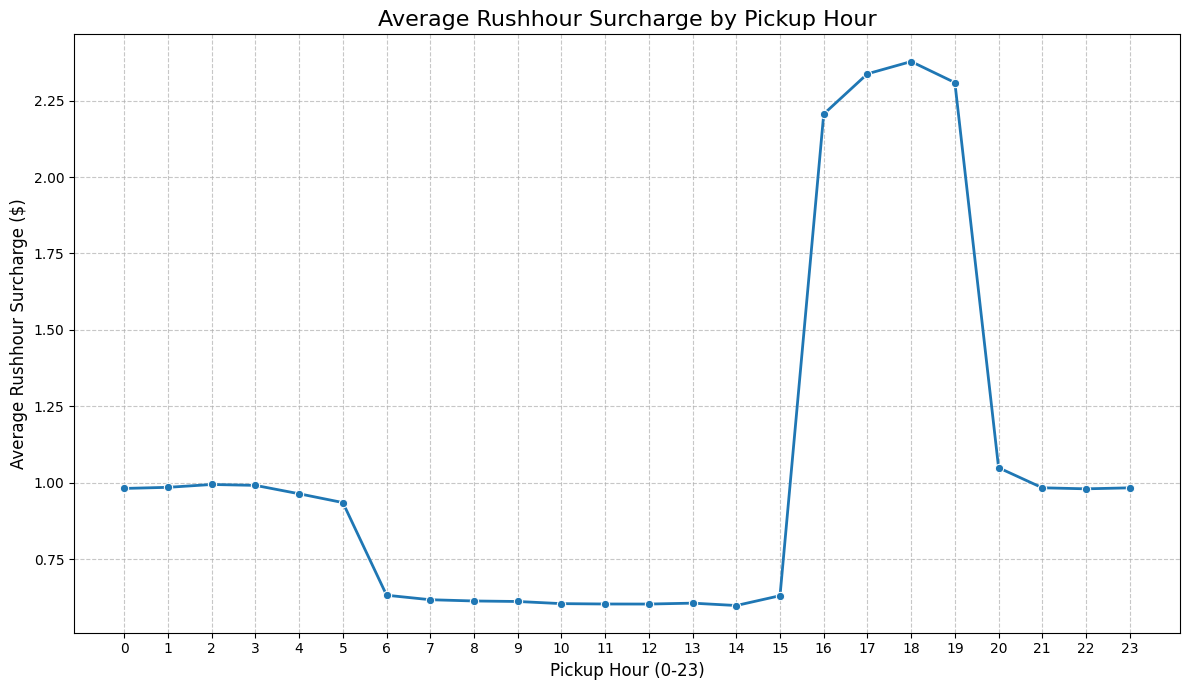

In [ ]:
con = duckdb.connect()

trip_file = 'yellow_2023_tripdata.parquet'

query = f"""
SELECT
    pickup_hour,
    AVG(rushhour_surcharge) AS average_rushhour_surcharge
FROM '{trip_file}'
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df_extra_by_hour = con.execute(query).fetchdf()
con.close()

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_extra_by_hour,
    x='pickup_hour',
    y='average_rushhour_surcharge', # Corrected column name here
    marker='o', # Add markers for each hour
    linewidth=2
)

plt.title('Average Rushhour Surcharge by Pickup Hour', fontsize=16)
plt.xlabel('Pickup Hour (0-23)', fontsize=12)
plt.ylabel('Average Rushhour Surcharge ($)', fontsize=12) # Corrected label here
plt.xticks(range(0, 24)) # Ensure all hours are displayed on the x-axis
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

6 AM - 3 PM : \$ 0.50 (Daytime charge)

4 PM - 7 PM : \$ 2.50 (Evening rush)

8 PM - 5 AM : \$ 1.00 (Nightime charge)

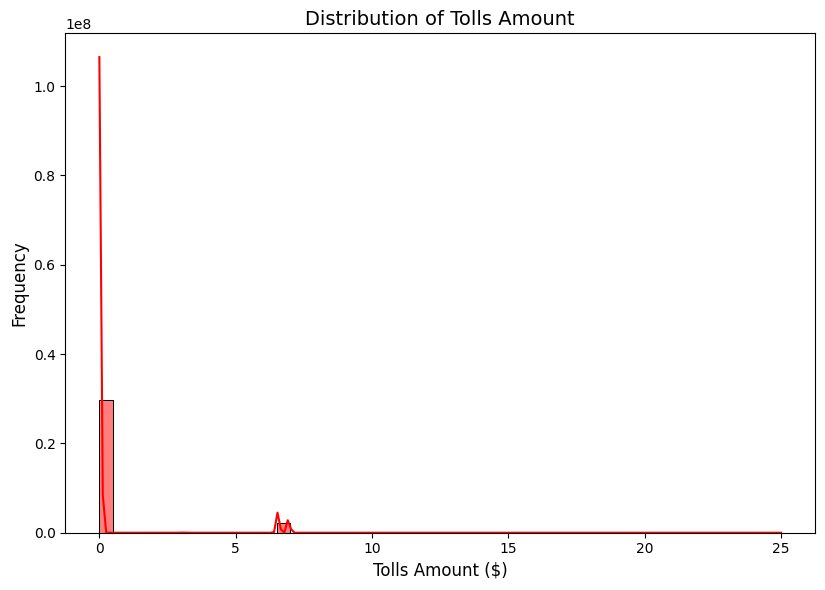

In [ ]:
con = duckdb.connect()

trip_file = 'yellow_2023_tripdata.parquet'

query = f"""
SELECT
    tolls_amount
FROM '{trip_file}'
"""

df_amounts = con.execute(query).fetchdf()

con.close()

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_amounts['tolls_amount'], bins=50, kde=True, color='red')
plt.title('Distribution of Tolls Amount', fontsize=14)
plt.xlabel('Tolls Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

This shows that most of the time, the driver avoids tolls and the data is highly skewed

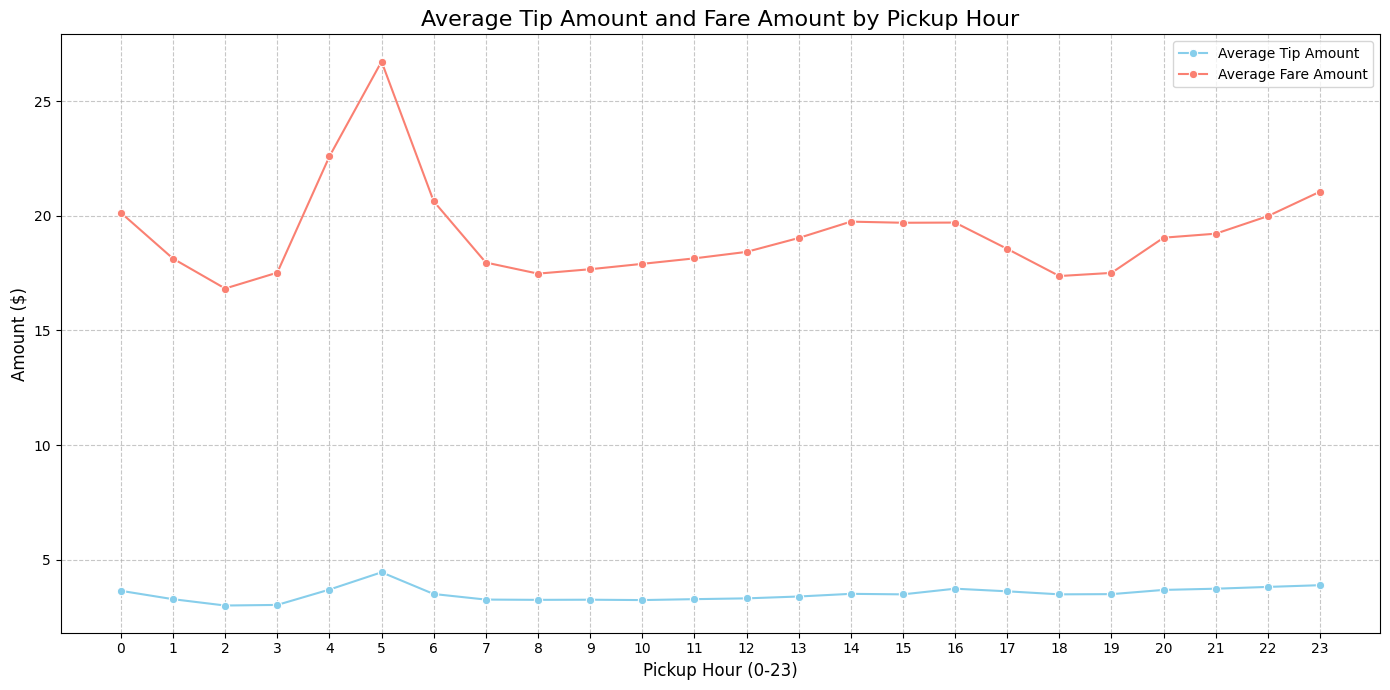

In [ ]:
con = duckdb.connect()

trip_file = 'yellow_2023_tripdata.parquet'

query = f"""
SELECT
    pickup_hour,
    AVG(tip_amount) AS average_tip_amount,
    AVG(fare_amount) AS average_fare_amount
FROM '{trip_file}'
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df_amounts_by_hour = con.execute(query).fetchdf()

con.close()

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_amounts_by_hour, x='pickup_hour', y='average_tip_amount', marker='o', label='Average Tip Amount', color='skyblue')
sns.lineplot(data=df_amounts_by_hour, x='pickup_hour', y='average_fare_amount', marker='o', label='Average Fare Amount', color='salmon')

plt.title('Average Tip Amount and Fare Amount by Pickup Hour', fontsize=16)
plt.xlabel('Pickup Hour (0-23)', fontsize=12)
plt.ylabel('Amount ($)', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

This shows that Tip Amount is usually a percentage of Fare Amount

* Ratecode Rules

If `PULocationID` or `DOLocationID` == 132, Then `RatecodeID` == 2

If `DOLocation` == 265 or 86, Then `RatecodeID` == 4

Else `RatecodeID` ==1

* Airport Fee Rules

If `pickup_month` == [1-3] AND (`RatecodeID` = 2 OR (`PULocationID` or `DOLocationID` == 132)), Then `airport_fee` = 1.25

If `pickup_month` == [4-12] AND (`RatecodeID` = 2 OR (`PULocationID` or `DOLocationID` == 132)), Then `airport_fee` = 1.75

* Airport Surcharge Rules

If `PULocationID` or `DOLocationID` == 138, Then `airport_surcharge` = 5.00

Else `airport_surcharge` = 0.00

* Rushhour Surcharge Rules

If `pickup_hour` = [0-5], Then `rushhour_surcharge` = 1.00

If `pickup_hour` = [6-15], Then `rushhour_surcharge` = 0.50

If `pickup_hour` = [16-19], Then `rushhour_surcharge` = 2.50

If `pickup_hour` = [20-23], Then `rushhour_surcharge` = 1.00

* Congestion Surcharge Rules

If `PULocationID` or `DOLocationID` == [236-239], Then `congestion_surcharge` = 2.50.

Else  then `congestion_surcharge` = 0.00

* Fixed Charges

`improvement_surcharge` = 1.00 (fixed, always)

`mta_tax` = 0.50 (fixed, always)

* Fare Amount Prediction

If `RatecodeID` = 2, Then `fare_amount` = 70

If `RatecodeID` = 1, Then `fare_amount` = Not fixed, apply Regression

If `RatecodeID` = 4, Then `fare_amount` = Not fixed, apply Regression

* Toll Amount Prediction

`tolls_amount` = 92% is 0, 8% is continuous, Use a regression model within a decision tree to predict

* Tip Amount Prediction

`tip_amount` = 20% is 0, 80% is some percentage of fare_amount, Use a decision tree to predict

* Total Amount Formula

`total_amount` = `fare_amount` + `airport_fee` + `airport_surcharge` + `rushhour_surcharge` + `congestion_surcharge` + `improvement_surcharge` + `mta_tax` + `tolls_amount` + `tip_amount`




In [7]:
trip_file = 'yellow_2023_tripdata.parquet'
temp_file = 'yellow_2023_tripdata_temp.parquet'

query = f"""
COPY (
    SELECT
        *,
        -- is_peaktime
        CASE
            WHEN pickup_hour BETWEEN 16 AND 19
                 AND congestion_surcharge = 2.50
            THEN 1 ELSE 0
        END AS is_peaktime,

        -- has_tolls
        CASE
            WHEN tolls_amount != 0 THEN 1 ELSE 0
        END AS has_tolls,

        -- tip_given
        CASE
            WHEN tip_amount != 0 THEN 1 ELSE 0
        END AS tip_given,

        -- tip_percentage
        CASE
            WHEN fare_amount = 0 THEN 0
            ELSE (tip_amount / fare_amount)
        END AS tip_percentage,

        -- is_LaGuardia
        CASE
            WHEN (PULocationID = 138 OR DOLocationID = 138)
                 AND Airport_fee = 5.00
            THEN 1 ELSE 0
        END AS is_LaGuardia

    FROM '{trip_file}'
) TO '{temp_file}' (FORMAT PARQUET);
"""

duckdb.sql(query)

if os.path.exists(temp_file):
    os.replace(temp_file, trip_file)
    print(f"Success! '{trip_file}' has been overwritten with the new columns.")
else:
    print("Error: Temporary file was not created.")

trip_file = 'yellow_2023_tripdata.parquet'
print(duckdb.sql(f"SELECT * FROM '{trip_file}' LIMIT 1").columns)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Success! 'yellow_2023_tripdata.parquet' has been overwritten with the new columns.
['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee', 'duration_min', 'pickup_hour', 'pickup_day', 'pickup_month', 'airport_surcharge', 'rushhour_surcharge', 'tip_amount', 'total_amount', 'average_speed_mph', 'is_peaktime', 'has_tolls', 'tip_given', 'tip_percentage', 'is_LaGuardia']


In [8]:
# Configuration
input_file = 'yellow_2023_tripdata.parquet'
train_path = 'train.parquet'
val_path = 'val.parquet'
test_path = 'test.parquet'

# Check if file exists
if not os.path.exists(input_file):
    print(f"Error: {input_file} not found.")
    exit()

print(f"Initializing DuckDB to stratify split {input_file}...")

# Connect to in-memory DB
con = duckdb.connect(database=':memory:')
con.execute("PRAGMA enable_progress_bar")
con.execute("PRAGMA memory_limit='7GB'")
con.execute("SELECT setseed(0.42);")

try:
    print("Step 1: Processing Data & Generating Split Key...")

    con.execute(f"""
        CREATE TABLE processed_data AS
        SELECT
            *,
            CASE WHEN tolls_amount > 0 THEN 1 ELSE 0 END AS has_tolls,
            CASE WHEN tip_amount > 0 THEN 1 ELSE 0 END AS tip_given,
            random() AS split_key
        FROM read_parquet('{input_file}')
    """)

    # Validation
    total_rows = con.execute("SELECT count(*) FROM processed_data").fetchone()[0]
    print(f"Total rows processed: {total_rows}")

    # 2. Export Train (0.0 to 0.7)
    print("Step 2: Exporting Train Set (70%)...")
    con.execute(f"""
        COPY (
            SELECT * EXCLUDE(split_key)
            FROM processed_data
            WHERE split_key < 0.7
        ) TO '{train_path}' (FORMAT 'parquet', COMPRESSION 'SNAPPY')
    """)

    # 3. Export Validation (0.7 to 0.85)
    print("Step 3: Exporting Validation Set (15%)...")
    con.execute(f"""
        COPY (
            SELECT * EXCLUDE(split_key)
            FROM processed_data
            WHERE split_key >= 0.7 AND split_key < 0.85
        ) TO '{val_path}' (FORMAT 'parquet', COMPRESSION 'SNAPPY')
    """)

    # 4. Export Test (0.85 to 1.0)
    print("Step 4: Exporting Test Set (15%)...")
    con.execute(f"""
        COPY (
            SELECT * EXCLUDE(split_key)
            FROM processed_data
            WHERE split_key >= 0.85
        ) TO '{test_path}' (FORMAT 'parquet', COMPRESSION 'SNAPPY')
    """)

    print("\n--- Success ---")
    print("Stratified split complete (via statistical sampling).")

except Exception as e:
    print(f"\nAn error occurred: {e}")

finally:
    con.close()

Initializing DuckDB to stratify split yellow_2023_tripdata.parquet...
Step 1: Processing Data & Generating Split Key...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total rows processed: 32036721
Step 2: Exporting Train Set (70%)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Step 3: Exporting Validation Set (15%)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Step 4: Exporting Test Set (15%)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Success ---
Stratified split complete (via statistical sampling).


--- Phase 1: Tuning on Subset (200000 rows) ---


[I 2025-12-20 12:30:45,611] A new study created in memory with name: no-name-cc0c6c8b-ffee-4dd1-9d3f-6630bb117fdc
[I 2025-12-20 12:30:47,953] Trial 0 finished with value: 1.3767035883314762 and parameters: {'learning_rate': 0.048223192980618224, 'max_depth': 8, 'subsample': 0.9401325728581748, 'colsample_bytree': 0.7908621831996044, 'gamma': 3.6296482456825236, 'min_child_weight': 2, 'reg_alpha': 4.034980556229561, 'reg_lambda': 5.106129581226513}. Best is trial 0 with value: 1.3767035883314762.
[I 2025-12-20 12:30:49,014] Trial 1 finished with value: 1.4138932772058064 and parameters: {'learning_rate': 0.14903526071409137, 'max_depth': 12, 'subsample': 0.7357537248182203, 'colsample_bytree': 0.8605683834142922, 'gamma': 1.2014287482453434, 'min_child_weight': 3, 'reg_alpha': 8.97034957582077, 'reg_lambda': 5.882503789682088}. Best is trial 0 with value: 1.3767035883314762.
[I 2025-12-20 12:30:49,849] Trial 2 finished with value: 1.3615956207273932 and parameters: {'learning_rate': 0.0


Best Trial Params: {'learning_rate': 0.0902740769892019, 'max_depth': 12, 'subsample': 0.8731267180274915, 'colsample_bytree': 0.9375176750560283, 'gamma': 3.8973178734105334, 'min_child_weight': 15, 'reg_alpha': 2.2724082840493987, 'reg_lambda': 5.573292767902967}

--- Phase 2: Training Final Model ---

Final Validation RMSE: $1.2166
Best Iteration: 168


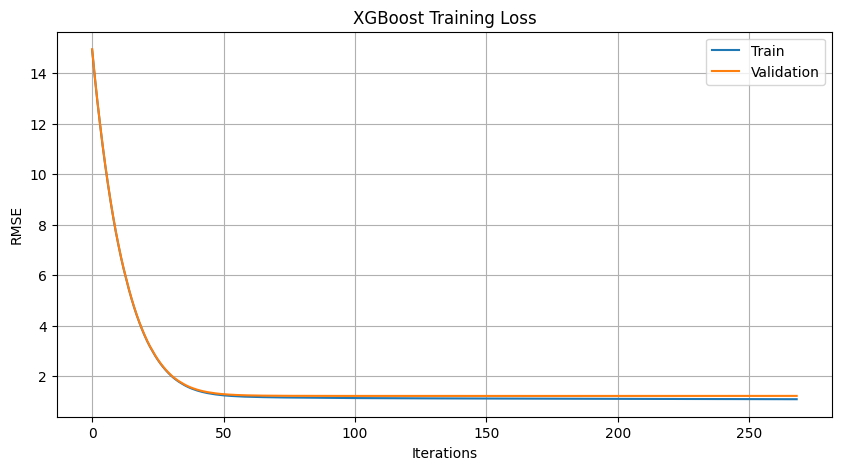

<Figure size 1000x600 with 0 Axes>

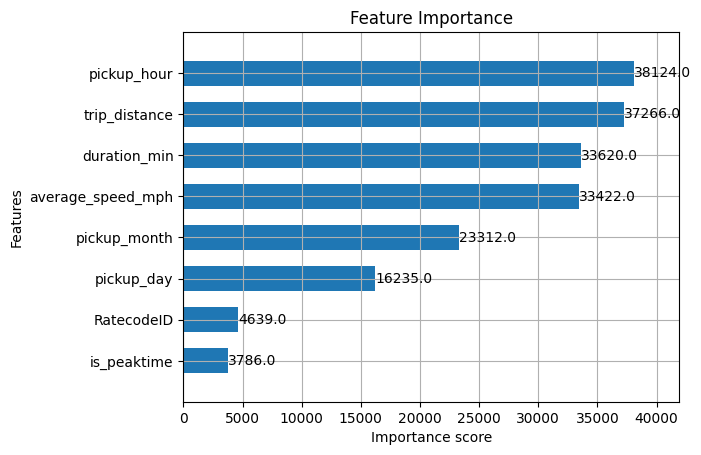


--- Sample Predictions ---
Actual: $38.00 | Predicted: $37.75 | Diff: $0.25
Actual: $11.40 | Predicted: $11.15 | Diff: $0.25
Actual: $26.80 | Predicted: $26.11 | Diff: $0.69
Actual: $4.40 | Predicted: $4.05 | Diff: $0.35
Actual: $12.80 | Predicted: $12.73 | Diff: $0.07
Model saved to models/xgb_fare_predictor.ubj


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [12:32:15] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [ ]:
# --- Configuration ---
train_path = 'train.parquet'
val_path = 'val.parquet'
model_dir = 'models'
model_save_path = os.path.join(model_dir, 'xgb_fare_predictor.ubj')

os.makedirs(model_dir, exist_ok=True)

# Tuning Configuration
TUNING_SAMPLE_SIZE = 200_000
VAL_SAMPLE_SIZE = 50_000
N_TRIALS = 40

features = [
    'trip_distance', 'RatecodeID', 'duration_min', 'pickup_hour',
    'pickup_day', 'pickup_month', 'average_speed_mph', 'is_peaktime',
    'is_LaGuardia'
]
target = "fare_amount"

# --- PHASE 1: Hyperparameter Tuning (Subset) ---
print(f"--- Phase 1: Tuning on Subset ({TUNING_SAMPLE_SIZE} rows) ---")

# Load subset to save RAM
df_train_sub = pd.read_parquet(train_path, columns=features + [target]).sample(n=TUNING_SAMPLE_SIZE, random_state=42)
df_val_sub = pd.read_parquet(val_path, columns=features + [target]).sample(n=VAL_SAMPLE_SIZE, random_state=42)

X_sub = df_train_sub[features]
y_sub = df_train_sub[target]
X_val_sub = df_val_sub[features]
y_val_sub = df_val_sub[target]

def objective(trial):

    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")

    params = {
        "n_estimators": 2000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "tree_method": "hist",
        "device": "cuda",
        "n_jobs": -1,
        "random_state": 42,
        "eval_metric": "rmse",
        "early_stopping_rounds": 50,
        "callbacks": [pruning_callback]
    }

    model = XGBRegressor(**params)

    model.fit(
        X_sub, y_sub,
        eval_set=[(X_val_sub, y_val_sub)],
        verbose=False
    )

    return model.best_score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS)

print("\nBest Trial Params:", study.best_trial.params)

# --- CLEANUP ---
del df_train_sub, df_val_sub, X_sub, y_sub, X_val_sub, y_val_sub
gc.collect()

# --- PHASE 2: Final Training (Full Dataset) ---
print("\n--- Phase 2: Training Final Model ---")

df_train = pd.read_parquet(train_path, columns=features + [target])
df_val = pd.read_parquet(val_path, columns=features + [target])

X_train_full = df_train[features]
y_train_full = df_train[target]
X_val_full = df_val[features]
y_val_full = df_val[target]

best_params = study.best_trial.params
best_params.update({
    "n_estimators": 5000,
    "learning_rate": best_params["learning_rate"] * 0.8,
    "tree_method": "hist",
    "device": "cuda",
    "n_jobs": -1,
    "random_state": 42,
    "eval_metric": "rmse",
    "early_stopping_rounds": 100
})

final_model = XGBRegressor(**best_params)

final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_val_full, y_val_full)],
    verbose=False
)

# --- RESULTS & PLOTTING ---
print(f"\nFinal Validation RMSE: ${final_model.best_score:.4f}")
print(f"Best Iteration: {final_model.best_iteration}")

# Plot RMSE Learning Curve
results = final_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('XGBoost Training Loss')
plt.grid(True)
plt.show()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plot_importance(final_model, max_num_features=10, importance_type='weight', height=0.6)
plt.title('Feature Importance')
plt.show()

# Sample Predictions
print("\n--- Sample Predictions ---")
sample_X = X_val_full.head(5)
sample_y = y_val_full.head(5)
preds = final_model.predict(sample_X)

for true, pred in zip(sample_y, preds):
    print(f"Actual: ${true:.2f} | Predicted: ${pred:.2f} | Diff: ${abs(true-pred):.2f}")

# Save Model
final_model.save_model(model_save_path)
del X_train_full, y_train_full, X_val_full, y_val_full, final_model, df_train, df_val
gc.collect()
print(f"Model saved to {model_save_path}")

--- Phase 1: Tuning Classifier (has_tolls) ---


[I 2025-12-20 13:39:37,902] A new study created in memory with name: classifier


Class Imbalance Ratio (scale_pos_weight): 12.95


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-20 13:39:40,643] Trial 0 finished with value: 0.07885891582708497 and parameters: {'learning_rate': 0.16052907964384414, 'max_depth': 3, 'subsample': 0.8150341444005265, 'colsample_bytree': 0.6202970345681088, 'gamma': 0.25562873306304246}. Best is trial 0 with value: 0.07885891582708497.
[I 2025-12-20 13:39:42,879] Trial 1 finished with value: 0.06489574400063178 and parameters: {'learning_rate': 0.15159092262723958, 'max_depth': 5, 'subsample': 0.9151141049385221, 'colsample_bytree': 0.640859431626438, 'gamma': 1.8792247906451554}. Best is trial 1 with value: 0.06489574400063178.
[I 2025-12-20 13:39:45,719] Trial 2 finished with value: 0.07148248081141953 and parameters: {'learning_rate': 0.034976052069415446, 'max_depth': 6, 'subsample': 0.9744772434595881, 'colsample_bytree': 0.6731830550360057, 'gamma': 1.7183654106798518}. Best is trial 1 with value: 0.06489574400063178.
[I 2025-12-20 13:39:48,392] Trial 3 finished with value: 0.09787978445757238 and parameters: {'lear

[I 2025-12-20 13:40:05,070] A new study created in memory with name: regressor


Regressor training samples: 14341


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-20 13:40:06,749] Trial 0 finished with value: 0.9349634537018131 and parameters: {'learning_rate': 0.015278814849216346, 'max_depth': 7, 'subsample': 0.7382427976004444, 'colsample_bytree': 0.609718569589431, 'gamma': 0.6269051917282664}. Best is trial 0 with value: 0.9349634537018131.
[I 2025-12-20 13:40:07,872] Trial 1 finished with value: 0.9391322892692013 and parameters: {'learning_rate': 0.015737779763804794, 'max_depth': 9, 'subsample': 0.856267799573097, 'colsample_bytree': 0.9403269018945372, 'gamma': 0.7336759150321348}. Best is trial 0 with value: 0.9349634537018131.
[I 2025-12-20 13:40:09,154] Trial 2 finished with value: 0.958357075724095 and parameters: {'learning_rate': 0.010245555086209036, 'max_depth': 3, 'subsample': 0.8978866523612191, 'colsample_bytree': 0.667284458444655, 'gamma': 2.134608788777148}. Best is trial 0 with value: 0.9349634537018131.
[I 2025-12-20 13:40:09,579] Trial 3 finished with value: 0.9476778782926013 and parameters: {'learning_rate'

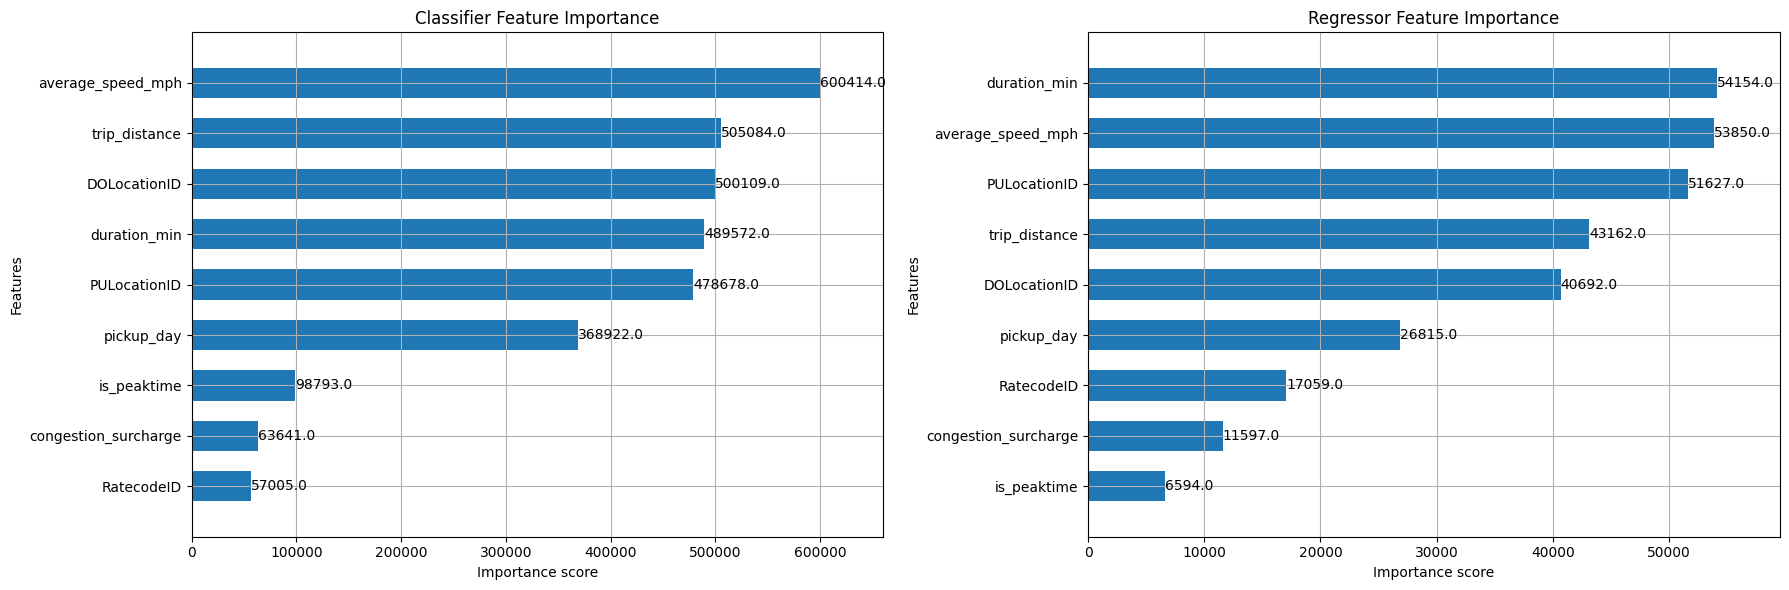


Pipeline complete! Models and plots saved.


30

In [ ]:
# --- Configuration ---
train_path = 'train.parquet'
val_path = 'val.parquet'
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

clf_model_path = os.path.join(model_dir, 'xgb_classifier_tolls.ubj')
reg_model_path = os.path.join(model_dir, 'xgb_regressor_tolls.ubj')

N_TRIALS = 20
TUNING_SAMPLE_SIZE = 200_000
VAL_SAMPLE_SIZE = 50_000

input_features = [
    'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
    'duration_min', 'is_peaktime', 'pickup_day', 'average_speed_mph',
    'is_LaGuardia', 'congestion_surcharge'
]

target_class = "has_tolls"
target_reg = "tolls_amount"


def load_data_optimized(path, columns, sample_size=None, filter_tolls=False):
    """Load parquet with optimized dtypes and optional sampling/filtering."""
    df = pd.read_parquet(path, columns=columns)

    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Optimize dtypes to reduce memory
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')

    if filter_tolls and target_class in df.columns:
        df = df[df[target_class] == 1].copy()
        gc.collect()

    return df


def create_base_params(trial, scale_pos_weight=None):
    """Shared parameter space for both models."""
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'tree_method': 'hist',
        'device': 'cuda',
        'n_jobs': -1,
        'random_state': 42,
        'early_stopping_rounds': 50
    }

    if scale_pos_weight is not None:
        params['scale_pos_weight'] = scale_pos_weight
        params['eval_metric'] = 'logloss'
    else:
        params['eval_metric'] = 'rmse'

    return params


# PHASE 1: TUNE CLASSIFIER
print(f"--- Phase 1: Tuning Classifier ({target_class}) ---")

df_train_clf = load_data_optimized(
    train_path,
    input_features + [target_class],
    TUNING_SAMPLE_SIZE
)
df_val_clf = load_data_optimized(
    val_path,
    input_features + [target_class],
    VAL_SAMPLE_SIZE
)

# Calculate class imbalance
num_pos = df_train_clf[target_class].sum()
num_neg = len(df_train_clf) - num_pos
scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0
print(f"Class Imbalance Ratio (scale_pos_weight): {scale_pos_weight:.2f}")


def objective_clf(trial):
    params = create_base_params(trial, scale_pos_weight)
    params['callbacks'] = [XGBoostPruningCallback(trial, "validation_0-logloss")]

    model = XGBClassifier(**params)
    model.fit(
        df_train_clf[input_features],
        df_train_clf[target_class],
        eval_set=[(df_val_clf[input_features], df_val_clf[target_class])],
        verbose=False
    )

    return model.best_score


study_clf = optuna.create_study(direction='minimize', study_name='classifier')
study_clf.optimize(objective_clf, n_trials=N_TRIALS, show_progress_bar=True)
best_params_clf = study_clf.best_params
print(f"Best Classifier Params: {best_params_clf}")

# Cleanup
del df_train_clf, df_val_clf, study_clf
gc.collect()


# PHASE 2: TUNE REGRESSOR
print(f"\n--- Phase 2: Tuning Regressor ({target_reg}) ---")

df_train_reg = load_data_optimized(
    train_path,
    input_features + [target_class, target_reg],
    TUNING_SAMPLE_SIZE,
    filter_tolls=True
)
df_val_reg = load_data_optimized(
    val_path,
    input_features + [target_class, target_reg],
    VAL_SAMPLE_SIZE,
    filter_tolls=True
)

print(f"Regressor training samples: {len(df_train_reg)}")


def objective_reg(trial):
    params = create_base_params(trial)
    params['callbacks'] = [XGBoostPruningCallback(trial, "validation_0-rmse")]

    model = XGBRegressor(**params)
    model.fit(
        df_train_reg[input_features],
        df_train_reg[target_reg],
        eval_set=[(df_val_reg[input_features], df_val_reg[target_reg])],
        verbose=False
    )

    return model.best_score


study_reg = optuna.create_study(direction='minimize', study_name='regressor')
study_reg.optimize(objective_reg, n_trials=N_TRIALS, show_progress_bar=True)
best_params_reg = study_reg.best_params
print(f"Best Regressor Params: {best_params_reg}")

# Cleanup
del df_train_reg, df_val_reg, study_reg
gc.collect()


# PHASE 3: FINAL TRAINING
print("\n--- Phase 3: Final Training on Full Dataset ---")

# Train Classifier
print("Training Final Classifier...")
df_train_full = load_data_optimized(train_path, input_features + [target_class])

best_params_clf.update({
    'n_estimators': 3000,
    'tree_method': 'hist',
    'device': 'cuda',
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss',
    'random_state': 42
})

final_clf = XGBClassifier(**best_params_clf)
final_clf.fit(df_train_full[input_features], df_train_full[target_class], verbose=False)
final_clf.save_model(clf_model_path)
print(f"Classifier saved to {clf_model_path}")

# Cleanup before regressor
del df_train_full, final_clf
gc.collect()

# Train Regressor
print("Training Final Regressor...")
df_train_full = load_data_optimized(
    train_path,
    input_features + [target_class, target_reg],
    filter_tolls=True
)

best_params_reg.update({
    'n_estimators': 3000,
    'tree_method': 'hist',
    'device': 'cuda',
    'n_jobs': -1,
    'eval_metric': 'rmse',
    'random_state': 42
})

final_reg = XGBRegressor(**best_params_reg)
final_reg.fit(df_train_full[input_features], df_train_full[target_reg], verbose=False)
final_reg.save_model(reg_model_path)
print(f"Regressor saved to {reg_model_path}")

# Cleanup
del df_train_full, final_reg
gc.collect()


# PHASE 4: EVALUATION
print("\n--- Phase 4: Final Pipeline Evaluation ---")

df_val = load_data_optimized(val_path, input_features + [target_class, target_reg])

# Load models
loaded_clf = XGBClassifier()
loaded_clf.load_model(clf_model_path)
loaded_reg = XGBRegressor()
loaded_reg.load_model(reg_model_path)

# Predictions
val_class_preds = loaded_clf.predict(df_val[input_features])
final_predictions = np.zeros(len(df_val), dtype=np.float32)

# Predict amounts only for predicted toll cases
toll_mask = val_class_preds == 1
if toll_mask.sum() > 0:
    final_predictions[toll_mask] = loaded_reg.predict(
        df_val.loc[toll_mask, input_features]
    )

# Metrics
actual_values = df_val[target_reg].values
rmse = np.sqrt(mean_squared_error(actual_values, final_predictions))
mae = mean_absolute_error(actual_values, final_predictions)
f1 = f1_score(df_val[target_class], val_class_preds)

print(f"\n=== FINAL PIPELINE METRICS ===")
print(f"Classification F1 Score: {f1:.4f}")
print(f"Pipeline RMSE: ${rmse:.4f}")
print(f"Pipeline MAE:  ${mae:.4f}")

# Feature Importance Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plot_importance(
    loaded_clf,
    max_num_features=10,
    importance_type='weight',
    height=0.6,
    ax=ax1,
    title="Classifier Feature Importance"
)
plot_importance(
    loaded_reg,
    max_num_features=10,
    importance_type='weight',
    height=0.6,
    ax=ax2,
    title="Regressor Feature Importance"
)
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nPipeline complete! Models and plots saved.")

# Final cleanup
del df_val, val_class_preds, final_predictions, loaded_clf, loaded_reg
gc.collect()

--- Phase 1: Tuning Classifier (tip_given) ---


[I 2025-12-21 09:32:14,938] A new study created in memory with name: tip_classifier


Class Imbalance Ratio (scale_pos_weight): 0.26
Positive samples: 159,162 (79.58%)


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-21 09:32:15,988] Trial 0 finished with value: 0.659738067067787 and parameters: {'learning_rate': 0.17918068637159845, 'max_depth': 10, 'subsample': 0.8641470673961011, 'colsample_bytree': 0.7298857936356399, 'gamma': 1.9217347294658371}. Best is trial 0 with value: 0.659738067067787.
[I 2025-12-21 09:32:16,723] Trial 1 finished with value: 0.6682529608124494 and parameters: {'learning_rate': 0.08944671434704105, 'max_depth': 6, 'subsample': 0.6456270521735047, 'colsample_bytree': 0.7912563757432975, 'gamma': 3.7925081562248546}. Best is trial 0 with value: 0.659738067067787.
[I 2025-12-21 09:32:18,309] Trial 2 finished with value: 0.6333599495815113 and parameters: {'learning_rate': 0.1859780081266618, 'max_depth': 12, 'subsample': 0.8487608497312562, 'colsample_bytree': 0.8305769435021108, 'gamma': 0.7950222821559594}. Best is trial 2 with value: 0.6333599495815113.
[I 2025-12-21 09:32:23,062] Trial 3 finished with value: 0.6347279465589114 and parameters: {'learning_rate'

[I 2025-12-21 09:32:33,859] A new study created in memory with name: tip_regressor


Regressor training samples: 159,162
Mean tip percentage: 0.2582


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-21 09:32:34,231] Trial 0 finished with value: 0.08119495642873076 and parameters: {'learning_rate': 0.11031788900359316, 'max_depth': 3, 'subsample': 0.7498037299775246, 'colsample_bytree': 0.9919835663430014, 'gamma': 4.263927503615409}. Best is trial 0 with value: 0.08119495642873076.
[I 2025-12-21 09:32:34,800] Trial 1 finished with value: 0.08071362091988815 and parameters: {'learning_rate': 0.0331322904315132, 'max_depth': 12, 'subsample': 0.8065690087149777, 'colsample_bytree': 0.928730349106186, 'gamma': 2.077931756684874}. Best is trial 1 with value: 0.08071362091988815.
[I 2025-12-21 09:32:35,079] Trial 2 finished with value: 0.0810350437618507 and parameters: {'learning_rate': 0.08953902625177075, 'max_depth': 7, 'subsample': 0.9837768470115522, 'colsample_bytree': 0.8745233052653805, 'gamma': 4.071895041579584}. Best is trial 1 with value: 0.08071362091988815.
[I 2025-12-21 09:32:35,532] Trial 3 finished with value: 0.08080300828964483 and parameters: {'learning_r

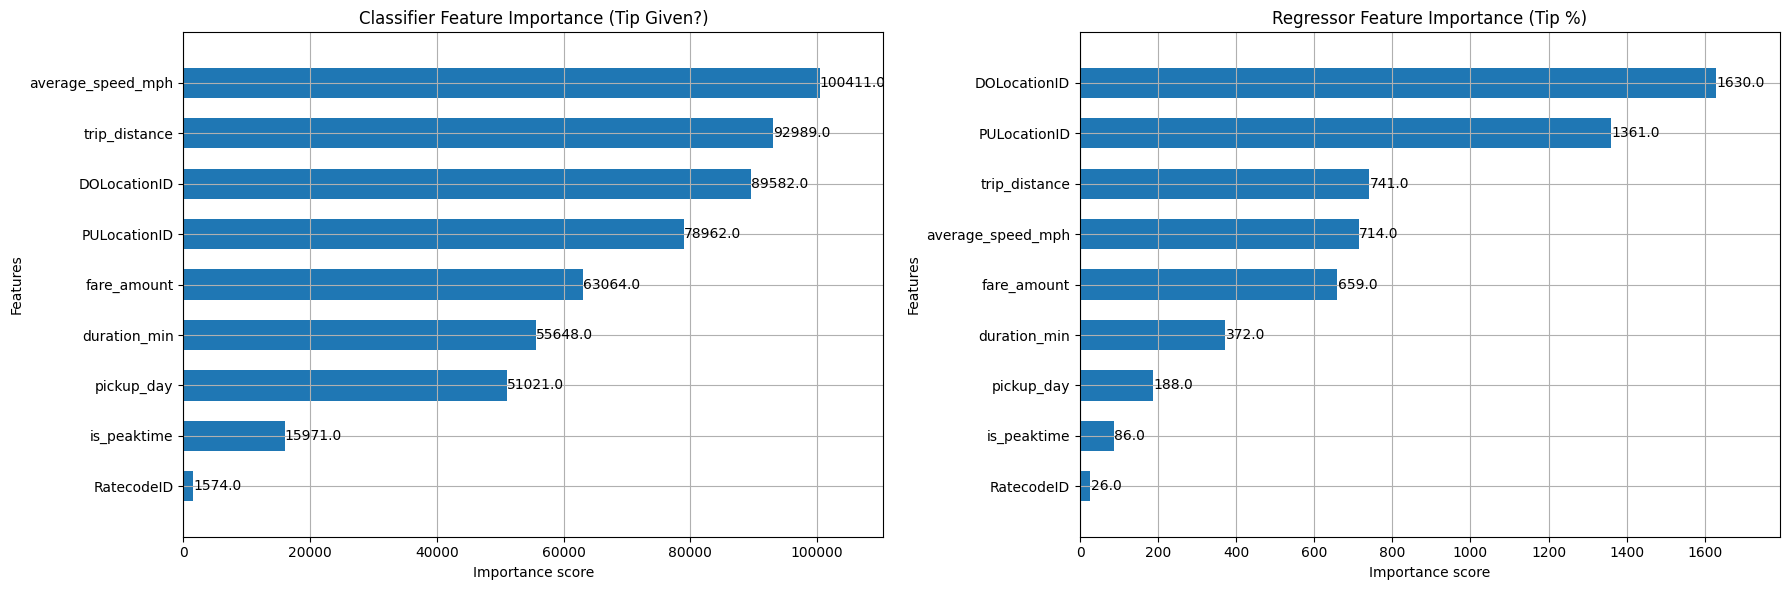


=== Sample Predictions (Actual Tips > 0) ===
 Actual_Tip_%  Predicted_Tip_%  Predicted_Tip_Given  Actual_Tip_Given
     0.131579         0.000000                    0                 1
     0.270175         0.270019                    1                 1
     0.078125         0.262097                    1                 1
     0.286022         0.300529                    1                 1
     0.142857         0.191135                    1                 1
     0.172414         0.385055                    1                 1
     0.176606         0.228570                    1                 1
     0.253521         0.000000                    0                 1
     0.259259         0.258702                    1                 1
     0.035461         0.000000                    0                 1

=== Sample Predictions (No Actual Tips) ===
 Actual_Tip_%  Predicted_Tip_%  Predicted_Tip_Given  Actual_Tip_Given
          0.0         0.000000                    0                 0

38

In [6]:
# --- Configuration ---
train_path = 'train.parquet'
val_path = 'val.parquet'
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

clf_model_path = os.path.join(model_dir, 'xgb_classifier_tips.ubj')
reg_model_path = os.path.join(model_dir, 'xgb_regressor_tips.ubj')

N_TRIALS = 20
TUNING_SAMPLE_SIZE = 200_000
VAL_SAMPLE_SIZE = 50_000

input_features = [
    'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
    'duration_min', 'is_peaktime', 'pickup_day', 'average_speed_mph',
    'is_LaGuardia', 'fare_amount'
]

target_class = "tip_given"
target_reg = "tip_percentage"


def load_data_optimized(path, columns, sample_size=None, filter_tips=False):
    """Load parquet with optimized dtypes and optional sampling/filtering."""
    df = pd.read_parquet(path, columns=columns)

    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Optimize dtypes to reduce memory usage
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')

    if filter_tips and target_class in df.columns:
        df = df[df[target_class] == 1].copy()
        gc.collect()

    return df


def create_base_params(trial, scale_pos_weight=None):
    """Shared parameter space for both classifier and regressor."""
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'tree_method': 'hist',
        'device': 'cuda',
        'n_jobs': -1,
        'random_state': 42,
        'early_stopping_rounds': 50
    }

    if scale_pos_weight is not None:
        params['scale_pos_weight'] = scale_pos_weight
        params['eval_metric'] = 'logloss'
    else:
        params['eval_metric'] = 'rmse'

    return params


# PHASE 1: TUNE CLASSIFIER
print(f"--- Phase 1: Tuning Classifier ({target_class}) ---")

df_train_clf = load_data_optimized(
    train_path,
    input_features + [target_class],
    TUNING_SAMPLE_SIZE
)
df_val_clf = load_data_optimized(
    val_path,
    input_features + [target_class],
    VAL_SAMPLE_SIZE
)

# Calculate class imbalance
num_pos = df_train_clf[target_class].sum()
num_neg = len(df_train_clf) - num_pos
scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0
print(f"Class Imbalance Ratio (scale_pos_weight): {scale_pos_weight:.2f}")
print(f"Positive samples: {num_pos:,} ({100*num_pos/len(df_train_clf):.2f}%)")


def objective_clf(trial):
    params = create_base_params(trial, scale_pos_weight)
    params['callbacks'] = [XGBoostPruningCallback(trial, "validation_0-logloss")]

    model = XGBClassifier(**params)
    model.fit(
        df_train_clf[input_features],
        df_train_clf[target_class],
        eval_set=[(df_val_clf[input_features], df_val_clf[target_class])],
        verbose=False
    )

    return model.best_score


study_clf = optuna.create_study(direction='minimize', study_name='tip_classifier')
study_clf.optimize(objective_clf, n_trials=N_TRIALS, show_progress_bar=True)
best_params_clf = study_clf.best_params
print(f"Best Classifier Params: {best_params_clf}")
print(f"Best Classifier Score: {study_clf.best_value:.6f}")

# Cleanup
del df_train_clf, df_val_clf, study_clf
gc.collect()


# PHASE 2: TUNE REGRESSOR
print(f"\n--- Phase 2: Tuning Regressor ({target_reg}) ---")

df_train_reg = load_data_optimized(
    train_path,
    input_features + [target_class, target_reg],
    TUNING_SAMPLE_SIZE,
    filter_tips=True
)
df_val_reg = load_data_optimized(
    val_path,
    input_features + [target_class, target_reg],
    VAL_SAMPLE_SIZE,
    filter_tips=True
)

print(f"Regressor training samples: {len(df_train_reg):,}")
print(f"Mean tip percentage: {df_train_reg[target_reg].mean():.4f}")


def objective_reg(trial):
    params = create_base_params(trial)
    params['callbacks'] = [XGBoostPruningCallback(trial, "validation_0-rmse")]

    model = XGBRegressor(**params)
    model.fit(
        df_train_reg[input_features],
        df_train_reg[target_reg],
        eval_set=[(df_val_reg[input_features], df_val_reg[target_reg])],
        verbose=False
    )

    return model.best_score


study_reg = optuna.create_study(direction='minimize', study_name='tip_regressor')
study_reg.optimize(objective_reg, n_trials=N_TRIALS, show_progress_bar=True)
best_params_reg = study_reg.best_params
print(f"Best Regressor Params: {best_params_reg}")
print(f"Best Regressor Score: {study_reg.best_value:.6f}")

# Cleanup
del df_train_reg, df_val_reg, study_reg
gc.collect()


# PHASE 3: FINAL TRAINING
print("\n--- Phase 3: Final Training on Full Dataset ---")

# Train Classifier
print("Training Final Classifier...")
df_train_full = load_data_optimized(train_path, input_features + [target_class])
print(f"Full training samples: {len(df_train_full):,}")

best_params_clf.update({
    'n_estimators': 3000,
    'tree_method': 'hist',
    'device': 'cuda',
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss',
    'random_state': 42
})

final_clf = XGBClassifier(**best_params_clf)
final_clf.fit(df_train_full[input_features], df_train_full[target_class], verbose=False)
final_clf.save_model(clf_model_path)
print(f"Classifier saved to {clf_model_path}")

# Cleanup before regressor
del df_train_full, final_clf
gc.collect()

# Train Regressor
print("Training Final Regressor (Filtered Data)...")
df_train_full = load_data_optimized(
    train_path,
    input_features + [target_class, target_reg],
    filter_tips=True
)
print(f"Regressor training samples: {len(df_train_full):,}")

best_params_reg.update({
    'n_estimators': 3000,
    'tree_method': 'hist',
    'device': 'cuda',
    'n_jobs': -1,
    'eval_metric': 'rmse',
    'random_state': 42
})

final_reg = XGBRegressor(**best_params_reg)
final_reg.fit(df_train_full[input_features], df_train_full[target_reg], verbose=False)
final_reg.save_model(reg_model_path)
print(f"Regressor saved to {reg_model_path}")

# Cleanup
del df_train_full, final_reg
gc.collect()


# PHASE 4: EVALUATION
print("\n--- Phase 4: Final Pipeline Evaluation ---")

df_val = load_data_optimized(val_path, input_features + [target_class, target_reg])
print(f"Validation samples: {len(df_val):,}")

# Load models
loaded_clf = XGBClassifier()
loaded_clf.load_model(clf_model_path)
loaded_reg = XGBRegressor()
loaded_reg.load_model(reg_model_path)

# Predictions
val_class_preds = loaded_clf.predict(df_val[input_features])
final_predictions = np.zeros(len(df_val), dtype=np.float32)

# Predict tip percentage only for predicted tip cases
tip_mask = val_class_preds == 1
if tip_mask.sum() > 0:
    final_predictions[tip_mask] = loaded_reg.predict(
        df_val.loc[tip_mask, input_features]
    )

# Metrics
actual_values = df_val[target_reg].values
rmse = np.sqrt(mean_squared_error(actual_values, final_predictions))
mae = mean_absolute_error(actual_values, final_predictions)
f1 = f1_score(df_val[target_class], val_class_preds)

# Additional classification metrics
actual_tips = df_val[target_class].values
true_pos = ((val_class_preds == 1) & (actual_tips == 1)).sum()
false_pos = ((val_class_preds == 1) & (actual_tips == 0)).sum()
true_neg = ((val_class_preds == 0) & (actual_tips == 0)).sum()
false_neg = ((val_class_preds == 0) & (actual_tips == 1)).sum()

precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
accuracy = (true_pos + true_neg) / len(df_val)

print(f"\n=== FINAL PIPELINE METRICS ===")
print(f"\nClassification Metrics:")
print(f"  F1 Score:  {f1:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"\nRegression Metrics:")
print(f"  Pipeline RMSE: {rmse:.4f}")
print(f"  Pipeline MAE:  {mae:.4f}")
print(f"\nPrediction Distribution:")
print(f"  Predicted tips: {tip_mask.sum():,} ({100*tip_mask.sum()/len(df_val):.2f}%)")
print(f"  Actual tips:    {actual_tips.sum():,} ({100*actual_tips.sum()/len(df_val):.2f}%)")

# Feature Importance Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plot_importance(
    loaded_clf,
    max_num_features=10,
    importance_type='weight',
    height=0.6,
    ax=ax1,
    title="Classifier Feature Importance (Tip Given?)"
)
plot_importance(
    loaded_reg,
    max_num_features=10,
    importance_type='weight',
    height=0.6,
    ax=ax2,
    title="Regressor Feature Importance (Tip %)"
)
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'feature_importance_tips.png'), dpi=150, bbox_inches='tight')
plt.show()

# Sample Predictions
comparison_df = pd.DataFrame({
    'Actual_Tip_%': actual_values,
    'Predicted_Tip_%': final_predictions,
    'Predicted_Tip_Given': val_class_preds,
    'Actual_Tip_Given': actual_tips
})

print("\n=== Sample Predictions (Actual Tips > 0) ===")
tips_sample = comparison_df[comparison_df['Actual_Tip_%'] > 0].head(10)
print(tips_sample.to_string(index=False))

print("\n=== Sample Predictions (No Actual Tips) ===")
no_tips_sample = comparison_df[comparison_df['Actual_Tip_%'] == 0].head(5)
print(no_tips_sample.to_string(index=False))

# Error Analysis
tip_cases = comparison_df[comparison_df['Actual_Tip_%'] > 0].copy()
if len(tip_cases) > 0:
    tip_cases['error'] = np.abs(tip_cases['Actual_Tip_%'] - tip_cases['Predicted_Tip_%'])
    print(f"\n=== Error Analysis (Actual Tips Only) ===")
    print(f"Mean Absolute Error: {tip_cases['error'].mean():.4f}")
    print(f"Median Absolute Error: {tip_cases['error'].median():.4f}")
    print(f"90th Percentile Error: {tip_cases['error'].quantile(0.9):.4f}")

print("\nPipeline complete! Models and plots saved.")

# Final cleanup
del df_val, val_class_preds, final_predictions, loaded_clf, loaded_reg
del comparison_df, tip_cases, tips_sample, no_tips_sample
gc.collect()

In [11]:
import os
import duckdb
import pandas as pd
import xgboost as xgb
import numpy as np
import time

# --- Configuration ---
TEST_FILE = 'test.parquet'
MODEL_DIR = 'models'
BATCH_SIZE = 200000

# Model Paths
FARE_MODEL_PATH = os.path.join(MODEL_DIR, 'xgb_fare_predictor.ubj')
TOLLS_CLF_PATH = os.path.join(MODEL_DIR, 'xgb_classifier_tolls.ubj')
TOLLS_REG_PATH = os.path.join(MODEL_DIR, 'xgb_regressor_tolls.ubj')
TIPS_CLF_PATH = os.path.join(MODEL_DIR, 'xgb_classifier_tips.ubj')
TIPS_REG_PATH = os.path.join(MODEL_DIR, 'xgb_regressor_tips.ubj')

# Feature Lists
FARE_FEATURES = [
    'trip_distance', 'RatecodeID', 'duration_min', 'pickup_hour',
    'pickup_day', 'pickup_month', 'average_speed_mph', 'is_peaktime',
    'is_LaGuardia'
]

TOLLS_FEATURES = [
    'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
    'duration_min', 'is_peaktime', 'pickup_day', 'average_speed_mph',
    'is_LaGuardia', 'congestion_surcharge'
]

TIPS_FEATURES = [
    'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
    'duration_min', 'is_peaktime', 'pickup_day', 'average_speed_mph',
    'is_LaGuardia', 'fare_amount'
]


class TaxiFarePredictor:
    """
    Optimized taxi fare prediction system using DuckDB and GPU Acceleration.
    """

    def __init__(self, model_dir=MODEL_DIR):
        """Initialize predictor with model paths."""
        self.model_dir = model_dir
        self.models_loaded = False
        self._load_models()

    def _load_models(self):
        """Load all XGBoost models and FORCE GPU usage."""
        print(f"Loading models from {self.model_dir}...")

        # --- GPU CONFIGURATION ---
        gpu_params = {'device': 'cuda'}

        try:
            self.fare_reg = xgb.XGBRegressor()
            self.fare_reg.load_model(FARE_MODEL_PATH)
            self.fare_reg.set_params(**gpu_params)

            self.tolls_clf = xgb.XGBClassifier()
            self.tolls_clf.load_model(TOLLS_CLF_PATH)
            self.tolls_clf.set_params(**gpu_params)

            self.tolls_reg = xgb.XGBRegressor()
            self.tolls_reg.load_model(TOLLS_REG_PATH)
            self.tolls_reg.set_params(**gpu_params)

            self.tips_clf = xgb.XGBClassifier()
            self.tips_clf.load_model(TIPS_CLF_PATH)
            self.tips_clf.set_params(**gpu_params)

            self.tips_reg = xgb.XGBRegressor()
            self.tips_reg.load_model(TIPS_REG_PATH)
            self.tips_reg.set_params(**gpu_params)

            self.models_loaded = True
            print("✅ Models loaded successfully on GPU!")

        except Exception as e:
            print(f"❌ Error loading models: {e}")
            print("Ensure you have a CUDA-capable GPU and xgboost installed.")
            raise

    def apply_business_logic_duckdb(self, conn, table_name='trips'):
        """
        Applies business logic using DuckDB SQL.
        Corrects RatecodeID logic and accurately calculates surcharges.
        """
        query = f"""
        CREATE OR REPLACE TABLE processed_trips AS
        SELECT
            *,
            -- 1. Ratecode Rules
            CASE
                -- If PULocationID or DOLocationID == 132 (JFK), Then RatecodeID == 2
                WHEN PULocationID = 132 OR DOLocationID = 132 THEN 2
                -- If DOLocation == 265 or 86, Then RatecodeID == 4
                WHEN DOLocationID = 265 OR DOLocationID = 86 THEN 4
                -- Else RatecodeID == 1
                ELSE 1
            END AS RatecodeID,

            -- 2. Airport Fee Rules (Seasonality check on JFK/Ratecode 2)
            CASE
                -- Only apply if JFK (132) is involved (which implies Ratecode 2 logic above)
                WHEN (PULocationID = 132 OR DOLocationID = 132) THEN
                    CASE
                        -- Months 1-3 -> $1.25
                        WHEN pickup_month BETWEEN 1 AND 3 THEN 1.25
                        -- Months 4-12 -> $1.75
                        WHEN pickup_month BETWEEN 4 AND 12 THEN 1.75
                        ELSE 0.00
                    END
                ELSE 0.00
            END AS airport_fee,

            -- 3. Airport Surcharge (LaGuardia Only)
            CASE
                WHEN PULocationID = 138 OR DOLocationID = 138 THEN 5.00
                ELSE 0.00
            END AS airport_surcharge,

            -- 4. Rushhour Surcharge (Full 24h coverage)
            CASE
                WHEN pickup_hour BETWEEN 0 AND 5 THEN 1.00
                WHEN pickup_hour BETWEEN 6 AND 15 THEN 0.50
                WHEN pickup_hour BETWEEN 16 AND 19 THEN 2.50
                WHEN pickup_hour BETWEEN 20 AND 23 THEN 1.00
                ELSE 0.00
            END AS rushhour_surcharge,

            -- 5. Congestion Surcharge
            CASE
                WHEN PULocationID IN (236, 237, 238, 239) OR
                     DOLocationID IN (236, 237, 238, 239) THEN 2.50
                ELSE 0.00
            END AS congestion_surcharge,

            -- Fixed Taxes
            0.50 AS mta_tax,
            1.00 AS improvement_surcharge,

            -- Feature placeholders needed for model columns (will be updated below)
            0 AS is_LaGuardia,
            0 AS is_peaktime,
            0 AS average_speed_mph
        FROM {table_name}
        """
        conn.execute(query)

        # FINAL SAFETY: Calculate derived features inside SQL
        conn.execute("""
            UPDATE processed_trips
            SET
                average_speed_mph = CASE WHEN duration_min > 0 THEN trip_distance/(duration_min/60.0) ELSE 0 END,
                is_LaGuardia = CASE WHEN PULocationID = 138 OR DOLocationID = 138 THEN 1 ELSE 0 END,
                is_peaktime = CASE WHEN pickup_hour BETWEEN 16 AND 19 THEN 1 ELSE 0 END
        """)

    def predict(self, test_file=TEST_FILE, custom_data=None):
        if not self.models_loaded:
            raise RuntimeError("Models not loaded!")

        conn = duckdb.connect(':memory:')

        if custom_data:
            return self._predict_single(conn, custom_data)
        else:
            return self._predict_batch(conn, test_file)

    def _predict_single(self, conn, data):
        """Predict for a single custom trip."""

        df_input = pd.DataFrame([data])
        conn.execute("CREATE TABLE trips AS SELECT * FROM df_input")

        self.apply_business_logic_duckdb(conn)
        df = conn.execute("SELECT * FROM processed_trips").df()

        result = self._run_predictions(df)
        conn.close()
        return PredictionResult(result, single=True)

    def _predict_batch(self, conn, test_file):
        """Predict for batch file using CHUNKED processing."""
        if not os.path.exists(test_file):
            raise FileNotFoundError(f"{test_file} not found!")

        # 1. Get Total Row Count
        print(f"Counting rows in {test_file}...")
        total_rows = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{test_file}')").fetchone()[0]
        print(f"Total Rows: {total_rows:,}")

        all_results = []
        actual_totals = []

        start_time = time.time()

        # 2. Loop through file in batches
        print(f"\n🚀 Starting Batch Processing (Batch Size: {BATCH_SIZE:,})...")

        for offset in range(0, total_rows, BATCH_SIZE):

            load_query = f"""
                CREATE OR REPLACE TABLE trips AS
                SELECT * FROM read_parquet('{test_file}')
                LIMIT {BATCH_SIZE} OFFSET {offset}
            """
            conn.execute(load_query)

            try:
                chunk_actuals = conn.execute("SELECT total_amount FROM trips").df()['total_amount']
                actual_totals.append(chunk_actuals)
            except:
                pass

            # Apply business logic
            self.apply_business_logic_duckdb(conn)

            # Convert to Pandas
            df_chunk = conn.execute("SELECT * FROM processed_trips").df()

            # Run Predictions
            df_result = self._run_predictions(df_chunk, verbose=False)
            all_results.append(df_result)

            # Progress update
            progress = min(((offset + BATCH_SIZE) / total_rows) * 100, 100)
            elapsed = time.time() - start_time
            print(f"  > Batch {offset//BATCH_SIZE + 1} completed | Progress: {progress:.1f}% | Time: {elapsed:.1f}s")

        print("\nCombining results...")
        final_df = pd.concat(all_results)

        rmse = None
        if actual_totals:
            final_actuals = pd.concat(actual_totals)

            # Evaluation
            print("Calculating metrics...")
            y_true = final_actuals.values
            y_pred = final_df['pred_total_amount'].values

            mae = np.mean(np.abs(y_true - y_pred))
            rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

            # Avoid division by zero for MAPE
            mask = y_true != 0
            mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

            print("\n" + "="*40)
            print(" MODEL PERFORMANCE (AGGREGATED) ")
            print("="*40)
            print(f"MAE  (Average Error):      {mae:.2f}")
            print(f"RMSE (Root MSE):           {rmse:.2f}")
            print(f"MAPE (Avg % Error):        {mape*100:.2f}%")
            print("="*40)

        print(f"Total rows processed: {len(final_df):,}")

        conn.close()
        return PredictionResult(final_df, single=False, rmse=rmse)

    def _run_predictions(self, df, verbose=True):
        """Run all model predictions on processed data."""
        if verbose: print("Running predictions...")

        # 1. Predict Fare
        pred_fares = self.fare_reg.predict(df[FARE_FEATURES])

        # Apply Rule:
        # Ratecode 2 = Fixed $70
        # Ratecode 1 & 4 = Regression (Variable)
        df['pred_fare_amount'] = np.where(
            df['RatecodeID'] == 2,
            70.0,
            pred_fares
        )
        df['pred_fare_amount'] = np.maximum(0, df['pred_fare_amount'])

        # 2. Predict Tolls
        has_tolls = self.tolls_clf.predict(df[TOLLS_FEATURES])
        tolls_amounts = self.tolls_reg.predict(df[TOLLS_FEATURES])

        df['pred_tolls_amount'] = np.maximum(0, has_tolls * tolls_amounts)

        # 3. Predict Tips (uses predicted fare)
        df['fare_amount'] = df['pred_fare_amount']
        tip_given = self.tips_clf.predict(df[TIPS_FEATURES])
        tip_percentages = self.tips_reg.predict(df[TIPS_FEATURES])

        raw_tips = df['pred_fare_amount'] * tip_percentages * tip_given
        df['pred_tip_amount'] = np.maximum(0, raw_tips)

        # 4. Calculate Total
        df['pred_total_amount'] = (
            df['pred_fare_amount'] +
            df['airport_fee'] +
            df['airport_surcharge'] +
            df['rushhour_surcharge'] +
            df['congestion_surcharge'] +
            df['improvement_surcharge'] +
            df['mta_tax'] +
            df['pred_tolls_amount'] +
            df['pred_tip_amount']
        )

        return df

class PredictionResult:
    """Container for prediction results with utility methods."""

    def __init__(self, df, single=False, rmse=None):
        self.df = df
        self.is_single = single
        self.rmse = rmse

        if single:
            row = df.iloc[0]
            self.fare_amount = float(row['pred_fare_amount'])
            self.tip_amount = float(row['pred_tip_amount'])
            self.tolls_amount = float(row['pred_tolls_amount'])
            self.airport_fee = float(row['airport_fee'])
            self.airport_surcharge = float(row['airport_surcharge'])
            self.rushhour_surcharge = float(row['rushhour_surcharge'])
            self.congestion_surcharge = float(row['congestion_surcharge'])
            self.improvement_surcharge = float(row['improvement_surcharge'])
            self.mta_tax = float(row['mta_tax'])
            self.total_amount = float(row['pred_total_amount'])

    def get_receipt(self, index=0):
        """Get formatted receipt for a trip."""
        if self.is_single:
            row = self.df.iloc[0]
        else:
            row = self.df.iloc[index]

        receipt = f"""
{'='*50}
                TAXI FARE RECEIPT
{'='*50}

Base Fare:                      ${row['pred_fare_amount']:>10.2f}
Tip:                            ${row['pred_tip_amount']:>10.2f}
Tolls:                          ${row['pred_tolls_amount']:>10.2f}

Surcharges & Fees:
  Airport Fee:                  ${row['airport_fee']:>10.2f}
  Airport Surcharge:            ${row['airport_surcharge']:>10.2f}
  Rush Hour Surcharge:          ${row['rushhour_surcharge']:>10.2f}
  Congestion Surcharge:         ${row['congestion_surcharge']:>10.2f}
  Improvement Surcharge:        ${row['improvement_surcharge']:>10.2f}
  MTA Tax:                      ${row['mta_tax']:>10.2f}

{'='*50}
TOTAL AMOUNT:                   ${row['pred_total_amount']:>10.2f}
{'='*50}
"""
        return receipt

    def get_total(self, index=0):
        """Get total amount for a specific trip."""
        if self.is_single:
            return self.total_amount
        return float(self.df.iloc[index]['pred_total_amount'])

    def get_breakdown(self, index=0):
        """Get dictionary of all charges (Rounded to 2 decimals)."""
        if self.is_single:
            row = self.df.iloc[0]
        else:
            row = self.df.iloc[index]

        return {
            'fare': round(float(row['pred_fare_amount']), 2),
            'tip': round(float(row['pred_tip_amount']), 2),
            'tolls': round(float(row['pred_tolls_amount']), 2),
            'airport_fee': round(float(row['airport_fee']), 2),
            'airport_surcharge': round(float(row['airport_surcharge']), 2),
            'rushhour_surcharge': round(float(row['rushhour_surcharge']), 2),
            'congestion_surcharge': round(float(row['congestion_surcharge']), 2),
            'improvement_surcharge': round(float(row['improvement_surcharge']), 2),
            'mta_tax': round(float(row['mta_tax']), 2),
            'total': round(float(row['pred_total_amount']), 2)
        }

if __name__ == "__main__":
    try:
        predictor = TaxiFarePredictor()

        # Batch prediction from file
        if os.path.exists(TEST_FILE):
            print("\n--- Batch Prediction ---")
            result = predictor.predict(test_file=TEST_FILE)
        else:
            print(f"\nSkipping batch test: {TEST_FILE} not found.")

        # Custom single prediction
        print("\n--- Custom Prediction ---")
        custom_trip = {
            'trip_distance': 17.5,      # REAL distance JFK -> Manhattan
            'PULocationID': 132,        # JFK
            'DOLocationID': 237,        # Manhattan
            'duration_min': 55,         # REAL duration
            'pickup_hour': 17,          # Rush hour
            'pickup_day': 3,
            'pickup_month': 6           # June
        }

        custom_result = predictor.predict(custom_data=custom_trip)
        print(f"Total: ${custom_result.total_amount:.2f}")
        print(custom_result.get_receipt())
        print(f"\nBreakdown: {custom_result.get_breakdown()}")

    except KeyboardInterrupt:
        print("\nProcess interrupted by user.")
    except Exception as e:
        print(f"\nAn error occurred: {e}")
        import traceback
        traceback.print_exc()

Loading models from models...
✅ Models loaded successfully on GPU!

--- Batch Prediction ---
Counting rows in test.parquet...
Total Rows: 4,804,265

🚀 Starting Batch Processing (Batch Size: 200,000)...
  > Batch 1 completed | Progress: 4.2% | Time: 1.7s
  > Batch 2 completed | Progress: 8.3% | Time: 3.7s
  > Batch 3 completed | Progress: 12.5% | Time: 5.5s
  > Batch 4 completed | Progress: 16.7% | Time: 7.0s
  > Batch 5 completed | Progress: 20.8% | Time: 8.5s
  > Batch 6 completed | Progress: 25.0% | Time: 10.0s
  > Batch 7 completed | Progress: 29.1% | Time: 11.5s
  > Batch 8 completed | Progress: 33.3% | Time: 13.0s
  > Batch 9 completed | Progress: 37.5% | Time: 14.6s
  > Batch 10 completed | Progress: 41.6% | Time: 16.6s
  > Batch 11 completed | Progress: 45.8% | Time: 18.2s
  > Batch 12 completed | Progress: 50.0% | Time: 19.7s
  > Batch 13 completed | Progress: 54.1% | Time: 21.2s
  > Batch 14 completed | Progress: 58.3% | Time: 22.7s
  > Batch 15 completed | Progress: 62.4% | T